# miRNA Classification for 2-6 with all list and 6-12 with FDR<0.05

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

In [2]:
path1 = Path("/Users/zainabnazari/mfuzz/data")
path2 = Path("/Users/zainabnazari/mfuzz/main")
path3 = Path("/Users/zainabnazari/mfuzz/result")

In [3]:
data_m = pd.read_excel(path1/"merged_mixed_miRNA.xlsx")

In [4]:
data_m['t0'] = 0.0
data_m = data_m[['miRNA_ID', 't0','baseMean', 'FC_2_6', 'FC_6_12']]
data_m

miRNA_ID   t0       baseMean    FC_2_6   FC_6_12
0    mmu-let-7a-5p  0.0  110787.030607 -0.045986  0.761791
1    mmu-let-7c-5p  0.0  130175.671522 -0.027348  0.823213
2    mmu-let-7d-3p  0.0    2312.332906 -0.032037 -0.592754
3    mmu-let-7d-5p  0.0   78718.562642  0.061417  0.577850
4    mmu-let-7e-5p  0.0   30012.253872  0.206413  0.717728
..             ...  ...            ...       ...       ...
79  mmu-miR-874-3p  0.0     754.812407  0.591251  0.902743
80  mmu-miR-92b-5p  0.0     165.425855 -0.538302  1.032048
81   mmu-miR-93-5p  0.0    1970.372303  0.045091  0.467843
82   mmu-miR-98-5p  0.0    4397.370544 -0.260280  0.413255
83  mmu-miR-99a-5p  0.0  457606.255932 -0.481329 -1.159393

[84 rows x 5 columns]

# Adding the Fold Change Values

In [5]:
# Define log2(expression) values relative to 2M
data_m['t1'] = data_m['t0'] + data_m['FC_2_6']
data_m['t2'] = data_m['t1'] + data_m['FC_6_12']

In [6]:
data_m[data_m['miRNA_ID']=='mmu-miR-666-5p']

miRNA_ID   t0    baseMean    FC_2_6   FC_6_12        t1        t2
75  mmu-miR-666-5p  0.0  273.882771 -1.119025  0.845991 -1.119025 -0.273034

# Evaluating the max values

In [7]:
abs(data_m['t1']).max()

1.95442495273275

In [8]:
abs(data_m['t2']).max()

3.98962196039584

# Classification and plotting

In [20]:

# plotting
sns.set(style='whitegrid', context='talk', palette='Set2')
rcParams['font.family'] = 'serif'
rcParams['figure.dpi'] = 300

# Define color palette
palette = sns.color_palette("husl", n_colors=10)  # Good distinct hues

# compute angle between time points (in degrees)
def compute_angle(delta_expr, delta_time=3.98):
    slope = delta_expr / delta_time
    angle = np.degrees(np.arctan(slope))
    return angle

# Classification function with angles
def classify_pattern(row, angle_thresh=3, steady_thresh=2.99):
    delta1 = row['t1'] - row['t0']
    delta2 = row['t2'] - row['t1']
    
    angle1 = compute_angle(delta1)
    angle2 = compute_angle(delta2)

    if abs(angle1) < steady_thresh and angle2 > angle_thresh:
        return 'Steady-then-Increase'
    elif abs(angle1) < steady_thresh and angle2 < -angle_thresh:
        return 'Steady-then-Decrease'
    elif angle1 > angle_thresh and angle2 < -angle_thresh:
        return 'Increase-then-Decrease'
    elif angle1 < -angle_thresh and angle2 > angle_thresh:
        return 'Decrease-then-Increase'
    elif angle1 > steady_thresh and angle2 > steady_thresh:
        return 'Gradual-Increase'
    elif angle1 < -steady_thresh and angle2 < -steady_thresh:
        return 'Gradual-Decrease'
    else:
        return 'Unclassified'

# Apply classification
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Plot grouped by pattern
timepoints = ['t0', 't1', 't2']
unique_patterns = data_m['pattern'].unique()

top_n = 5  # You can change this number


# Compute a "total change" metric
#data_m['total_change'] = (data_m['t1'] - data_m['t2']).abs()

# Custom total change computation based on pattern
def compute_total_change(row):
    pattern = row['pattern']
    fc_2_6 = row['FC_2_6']
    fc_6_12 = row['FC_6_12']

    if pattern in ['Gradual-Increase', 'Gradual-Decrease']:
        return abs(fc_2_6) + abs(fc_6_12)
    elif pattern in ['Steady-then-Increase', 'Steady-then-Decrease']:
        return abs(fc_6_12)
    elif pattern in ['Increase-then-Decrease', 'Decrease-then-Increase']:
        return abs(fc_6_12 - fc_2_6)
    else:
        return 0  # or np.nan if you'd prefer to ignore unclassified

# Apply classification first
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Then compute total change
data_m['total_change'] = data_m.apply(compute_total_change, axis=1)


# Apply classification
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Plot grouped by pattern
timepoints = ['t0', 't1', 't2']
unique_patterns = data_m['pattern'].unique();


# Optional: re-define your color palette once
palette = sns.color_palette("husl", n_colors=10)

def plot_mirna_pattern(pattern, top_n=5, data=data_m):
    """
    Plot miRNA expression for a given pattern type.

    Args:
        pattern (str): One of the classified patterns (e.g. 'Gradual-Increase')
        top_n (int): Number of top miRNAs to show by total expression change
        data (pd.DataFrame): DataFrame that includes columns t0, t1, t2, miRNA_ID, pattern, total_change
    """
    subset = data[data['pattern'] == pattern]
    if subset.empty:
        print(f"No data found for pattern: {pattern}")
        return

    top_subset = subset.nlargest(top_n, 'total_change')
    timepoints = ['t0', 't1', 't2']

    plt.figure(figsize=(8, 5))
    for i, (_, row) in enumerate(top_subset.iterrows()):
        color = palette[i % len(palette)]
        plt.plot(timepoints, row[timepoints], marker='o', linewidth=1.5, alpha=0.5, color=color)
        plt.text(timepoints[-1], row[timepoints[-1]], row['miRNA_ID'], fontsize=8, color=color,
                 verticalalignment='center', horizontalalignment='left')

    plt.title(f'Pattern: {pattern} (Top {top_n})', fontsize=16)
    plt.xlabel('Time Point', fontsize=14)
    plt.ylabel('Expression Level (log2 FC)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [11]:
row1 = data_m[data_m['miRNA_ID'] == 'mmu-miR-132-3p']
row1

miRNA_ID   t0      baseMean    FC_2_6   FC_6_12        t1        t2  \
20  mmu-miR-132-3p  0.0  25327.273119  0.460537  0.604433  0.460537  1.064969   

             pattern  total_change  
20  Gradual-Increase      0.604433

In [12]:
row2 = data_m[data_m['miRNA_ID'] == 'mmu-miR-10b-5p']
row2

miRNA_ID   t0   baseMean    FC_2_6   FC_6_12        t1        t2  \
9  mmu-miR-10b-5p  0.0  344.22461 -1.954425 -1.078278 -1.954425 -3.032703   

            pattern  total_change  
9  Gradual-Decrease      1.078278

In [13]:
row3 = data_m[data_m['miRNA_ID'] == 'mmu-miR-666-5p']
row3

miRNA_ID   t0    baseMean    FC_2_6   FC_6_12        t1        t2  \
75  mmu-miR-666-5p  0.0  273.882771 -1.119025  0.845991 -1.119025 -0.273034   

                   pattern  total_change  
75  Decrease-then-Increase      0.845991

# Saving the result in excel files

In [15]:
columns_to_save = ['miRNA_ID', 'baseMean', 'FC_2_6', 'FC_6_12']

# Apply pattern classification to each row
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Add 'pattern' to the columns to be saved
columns_to_export = columns_to_save + ['pattern']

# Dictionary to store DataFrames by pattern
pattern_groups = {}

# Save each group to a separate Excel file
for pattern in data_m['pattern'].unique():
    group_data = data_m[data_m['pattern'] == pattern][columns_to_export]
    pattern_groups[pattern] = group_data

    # Make filename safe: replace spaces and special characters
    safe_pattern = pattern.replace(' ', '_').replace('/', '_')
    filename = f"Mixed_miRNA_{safe_pattern}.xlsx"
    
    # Save to Excel
    group_data.to_excel(path3 / filename, index=False)


# Whole Table 

In [16]:
data_m

miRNA_ID   t0       baseMean    FC_2_6   FC_6_12        t1  \
0    mmu-let-7a-5p  0.0  110787.030607 -0.045986  0.761791 -0.045986   
1    mmu-let-7c-5p  0.0  130175.671522 -0.027348  0.823213 -0.027348   
2    mmu-let-7d-3p  0.0    2312.332906 -0.032037 -0.592754 -0.032037   
3    mmu-let-7d-5p  0.0   78718.562642  0.061417  0.577850  0.061417   
4    mmu-let-7e-5p  0.0   30012.253872  0.206413  0.717728  0.206413   
..             ...  ...            ...       ...       ...       ...   
79  mmu-miR-874-3p  0.0     754.812407  0.591251  0.902743  0.591251   
80  mmu-miR-92b-5p  0.0     165.425855 -0.538302  1.032048 -0.538302   
81   mmu-miR-93-5p  0.0    1970.372303  0.045091  0.467843  0.045091   
82   mmu-miR-98-5p  0.0    4397.370544 -0.260280  0.413255 -0.260280   
83  mmu-miR-99a-5p  0.0  457606.255932 -0.481329 -1.159393 -0.481329   

          t2                 pattern  total_change  
0   0.715804    Steady-then-Increase      0.761791  
1   0.795866    Steady-then-Increase      0.823213  
2  -0.624790    Steady-then-Decrease      0.592754  
3   0.639267    Steady-then-Increase      0.577850  
4   0.924141    Steady-then-Increase      0.717728  
..       ...                     ...           ...  
79  1.493993        Gradual-Increase      0.902743  
80  0.493747  Decrease-then-Increase      1.032048  
81  0.512934    Steady-then-Increase      0.467843  
82  0.152975  Decrease-then-Increase      0.413255  
83 -1.640722        Gradual-Decrease      1.159393  

[84 rows x 9 columns]

# Steady-then-Increase

In [17]:
data_r8 = pd.read_excel(path3/"Mixed_miRNA_Steady-then-Increase.xlsx")
data_r8.sort_values(by='FC_6_12', ascending=False, inplace=True)
data_r8.reset_index(drop=True)

miRNA_ID       baseMean    FC_2_6   FC_6_12               pattern
0     mmu-miR-770-5p     445.481180  0.028156  1.138875  Steady-then-Increase
1      mmu-let-7c-5p  130175.671522 -0.027348  0.823213  Steady-then-Increase
2     mmu-miR-431-5p     691.421670  0.163425  0.812903  Steady-then-Increase
3      mmu-let-7a-5p  110787.030607 -0.045986  0.761791  Steady-then-Increase
4     mmu-miR-674-5p    3298.916315  0.121216  0.755517  Steady-then-Increase
5      mmu-let-7e-5p   30012.253872  0.206413  0.717728  Steady-then-Increase
6    mmu-miR-487b-3p    4621.151523  0.014220  0.688399  Steady-then-Increase
7   mmu-miR-1843a-5p     329.228117  0.030748  0.627547  Steady-then-Increase
8     mmu-miR-382-5p   16856.943588  0.094989  0.622405  Steady-then-Increase
9     mmu-miR-203-3p     262.949025  0.205104  0.612624  Steady-then-Increase
10     mmu-let-7d-5p   78718.562642  0.061417  0.577850  Steady-then-Increase
11   mmu-miR-181a-5p   32199.237097 -0.106884  0.534999  Steady-then-Increase
12    mmu-miR-598-3p    1682.573154  0.151195  0.528977  Steady-then-Increase
13     mmu-let-7g-5p   69959.998517 -0.103429  0.524223  Steady-then-Increase
14     mmu-miR-93-5p    1970.372303  0.045091  0.467843  Steady-then-Increase
15    mmu-miR-541-5p    9749.264516 -0.037896  0.329075  Steady-then-Increase

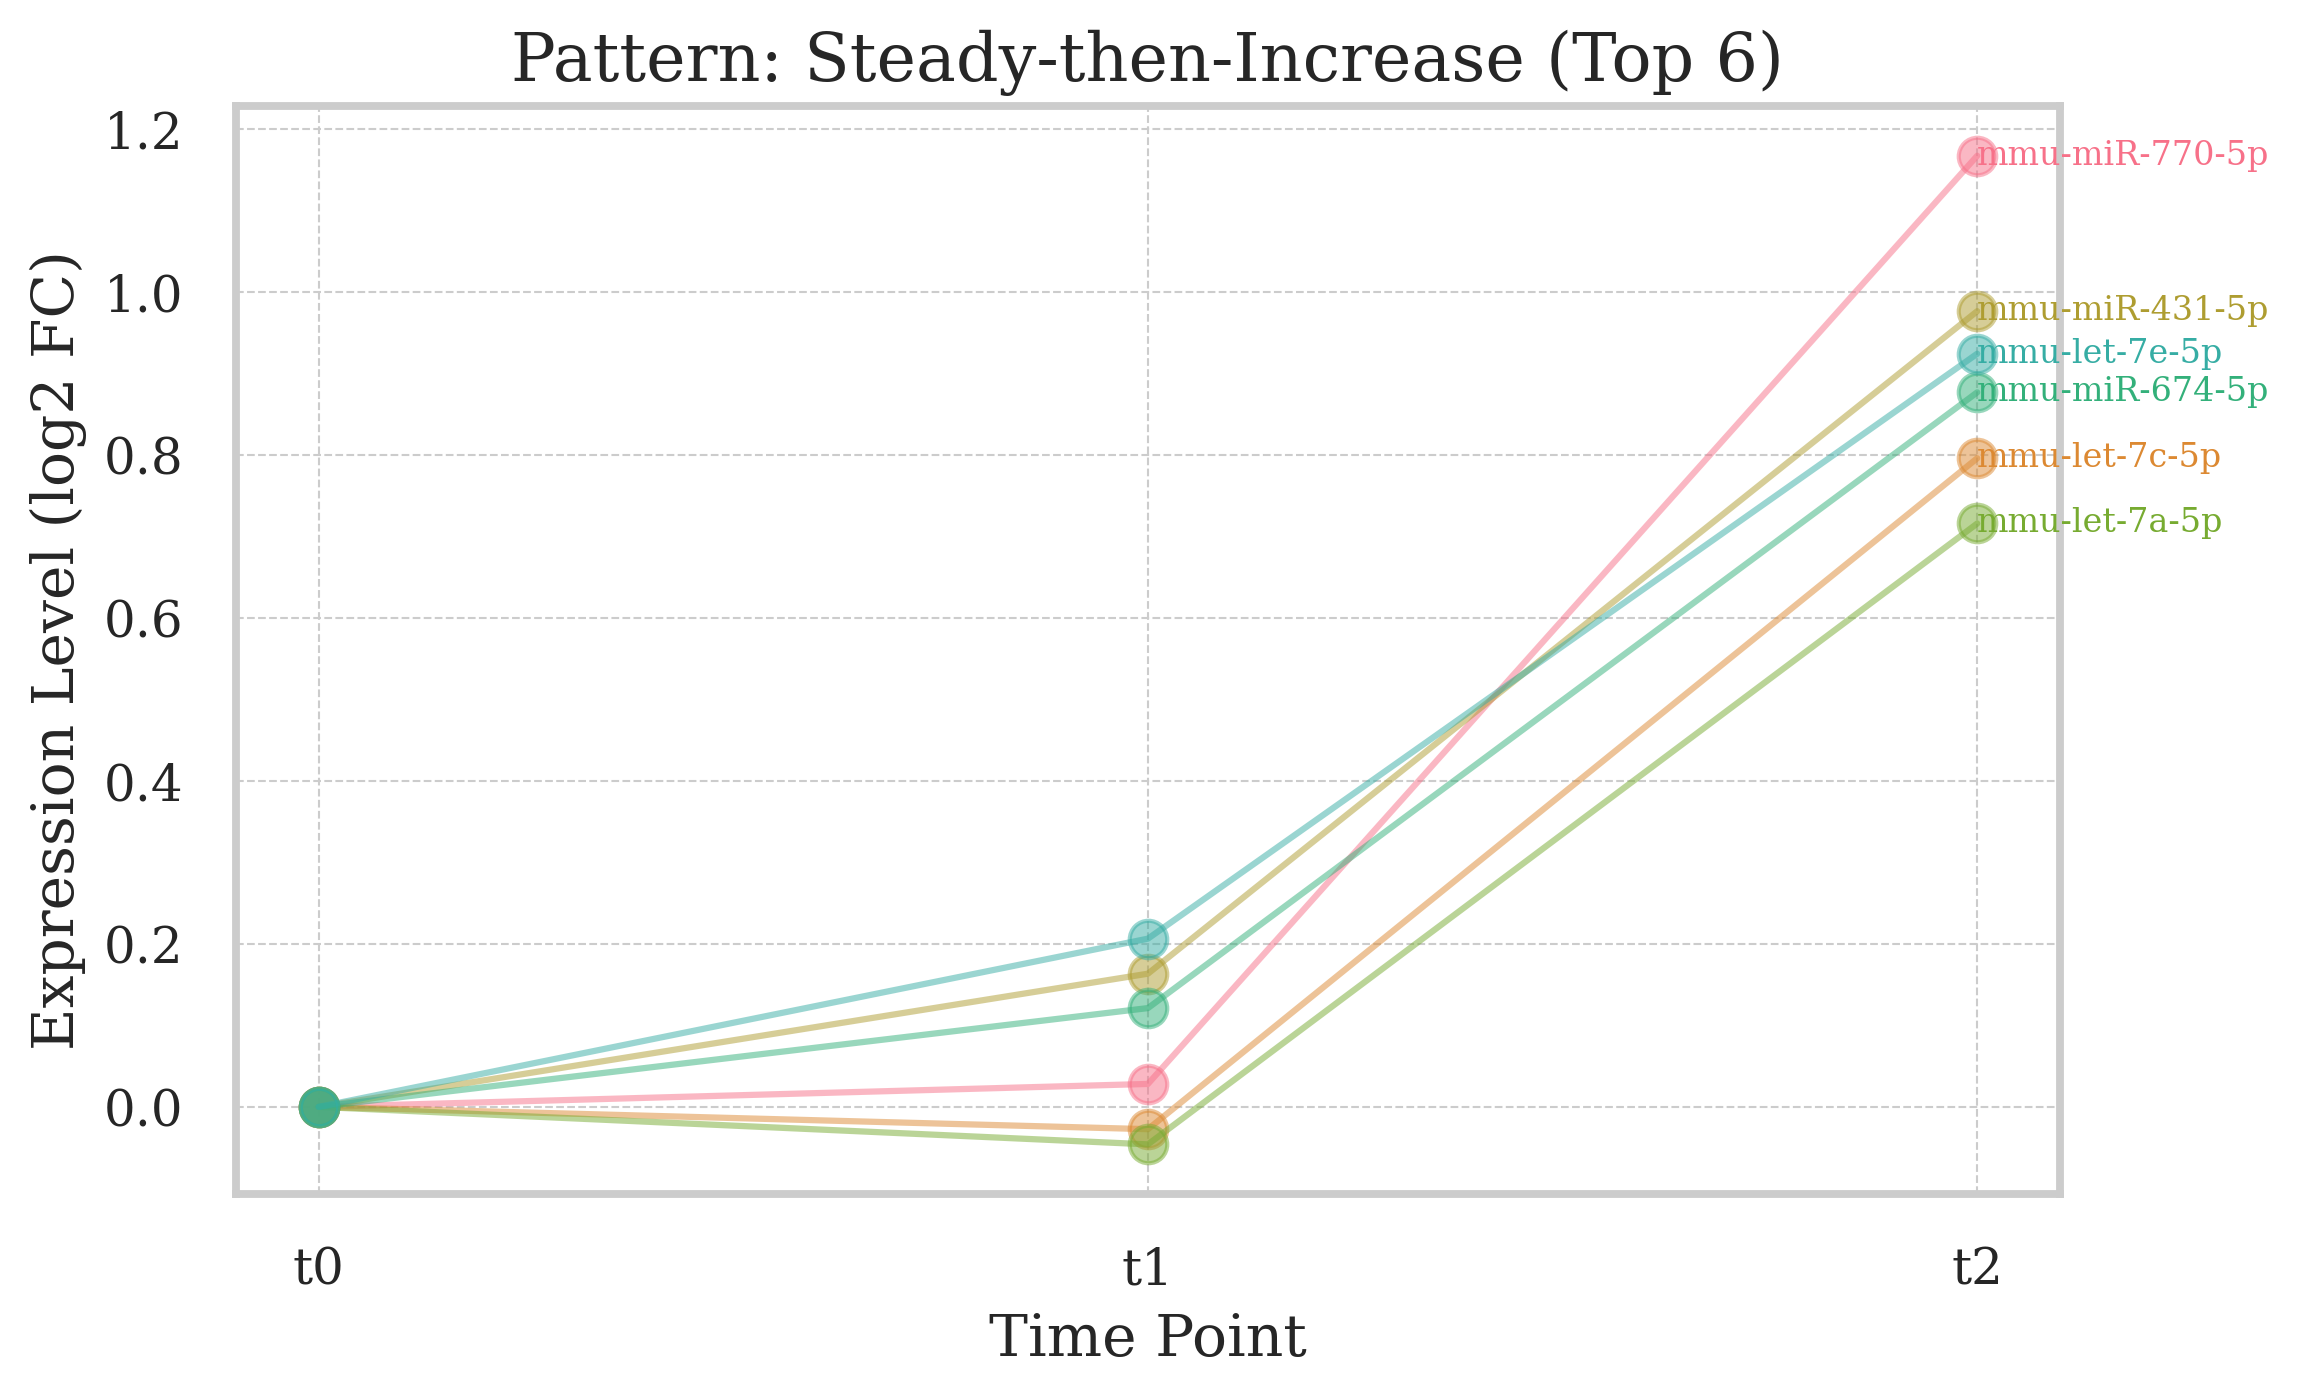

In [35]:
plot_mirna_pattern('Steady-then-Increase', top_n=6)


# Steady-then-Decrease

In [488]:
data_r9 = pd.read_excel(path3/"Mixed_miRNA_Steady-then-Decrease.xlsx")
data_r9.sort_values(by='FC_6_12', ascending=True, inplace=True)
data_r9.reset_index(drop=True)

miRNA_ID       baseMean    FC_2_6   FC_6_12               pattern
0    mmu-miR-365-3p    5461.756056 -0.169739 -1.519665  Steady-then-Decrease
1    mmu-miR-664-5p     123.874039 -0.166738 -1.505192  Steady-then-Decrease
2   mmu-miR-142a-3p     136.317884  0.151047 -1.212460  Steady-then-Decrease
3    mmu-miR-671-5p     153.338612  0.168238 -1.149978  Steady-then-Decrease
4    mmu-miR-139-3p     709.052089  0.000304 -1.146473  Steady-then-Decrease
5      mmu-miR-5126     159.097737  0.015217 -1.075592  Steady-then-Decrease
6   mmu-miR-3072-3p     616.523161  0.051817 -1.075494  Steady-then-Decrease
7   mmu-miR-1224-5p     801.632958  0.122276 -0.865022  Steady-then-Decrease
8   mmu-miR-148a-3p    1481.633996  0.008871 -0.848948  Steady-then-Decrease
9   mmu-miR-125b-5p  220488.050199 -0.159802 -0.761519  Steady-then-Decrease
10   mmu-miR-30e-5p    1692.046402  0.191842 -0.747823  Steady-then-Decrease
11  mmu-miR-125a-5p   41369.554131 -0.099214 -0.684638  Steady-then-Decrease
12   mmu-miR-186-5p    1605.685478 -0.006581 -0.668962  Steady-then-Decrease
13    mmu-let-7d-3p    2312.332906 -0.032037 -0.592754  Steady-then-Decrease
14   mmu-miR-329-3p    5291.820014 -0.144906 -0.582870  Steady-then-Decrease
15   mmu-miR-384-5p    7723.729274  0.121404 -0.562172  Steady-then-Decrease
16   mmu-miR-331-3p    1148.986442  0.155150 -0.545152  Steady-then-Decrease

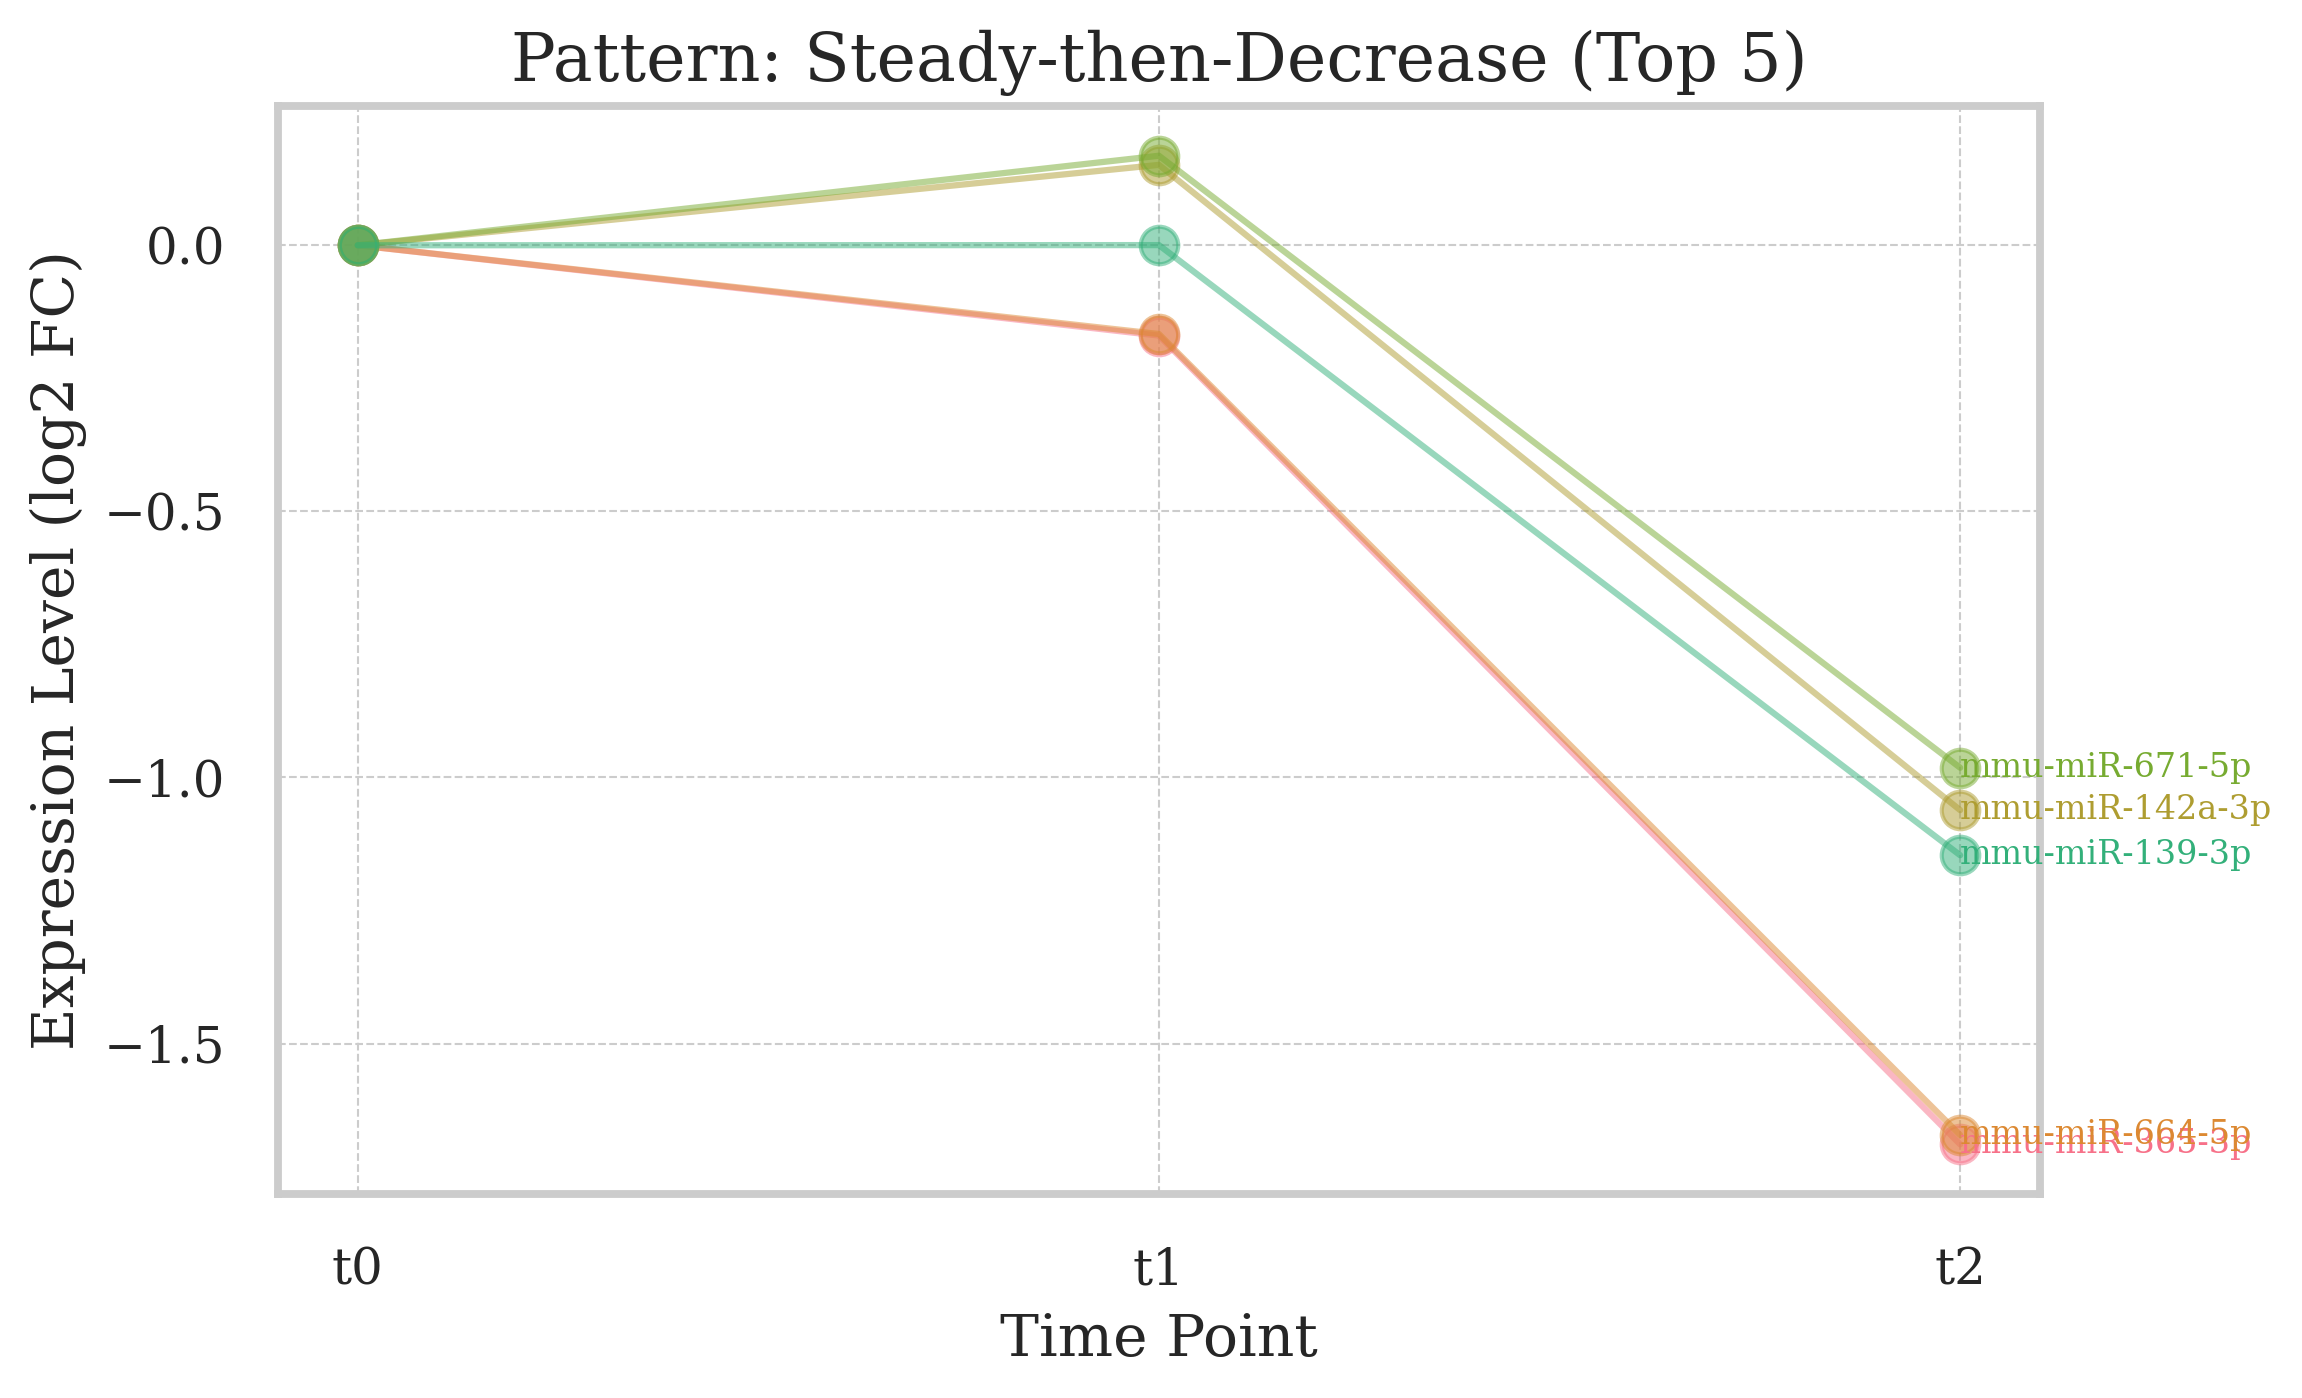

In [34]:
plot_mirna_pattern('Steady-then-Decrease', top_n=5)


# Decrease-then-Increase

In [36]:
data_r1 = pd.read_excel(path3/"Mixed_miRNA_Decrease-then-Increase.xlsx")

# Step 1: Subtract the columns row-wise and store in a new column
data_r1['expr_diff'] = data_r1['FC_6_12'] - data_r1['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r1_sorted = data_r1.sort_values(by='expr_diff', ascending=False,inplace=True)

data_r1.reset_index(drop=True, inplace=True)

data_r1

miRNA_ID       baseMean    FC_2_6   FC_6_12                 pattern  \
0   mmu-miR-323-5p     160.345824 -0.520892  1.532001  Decrease-then-Increase   
1   mmu-miR-666-5p     273.882771 -1.119025  0.845991  Decrease-then-Increase   
2   mmu-miR-92b-5p     165.425855 -0.538302  1.032048  Decrease-then-Increase   
3   mmu-miR-491-5p     108.902138 -0.451209  0.972796  Decrease-then-Increase   
4   mmu-miR-26a-5p  157964.101514 -0.407419  0.647320  Decrease-then-Increase   
5   mmu-miR-151-5p   13043.934471 -0.501917  0.550314  Decrease-then-Increase   
6   mmu-miR-187-3p     595.173118 -0.219092  0.687608  Decrease-then-Increase   
7   mmu-miR-30a-3p    4101.469088 -0.359026  0.504079  Decrease-then-Increase   
8    mmu-let-7i-5p   28686.771947 -0.253936  0.484150  Decrease-then-Increase   
9    mmu-let-7f-5p  106812.320845 -0.242987  0.474332  Decrease-then-Increase   
10   mmu-miR-98-5p    4397.370544 -0.260280  0.413255  Decrease-then-Increase   

    expr_diff  
0    2.052893  
1    1.965016  
2    1.570350  
3    1.424005  
4    1.054739  
5    1.052231  
6    0.906700  
7    0.863104  
8    0.738087  
9    0.717319  
10   0.673534

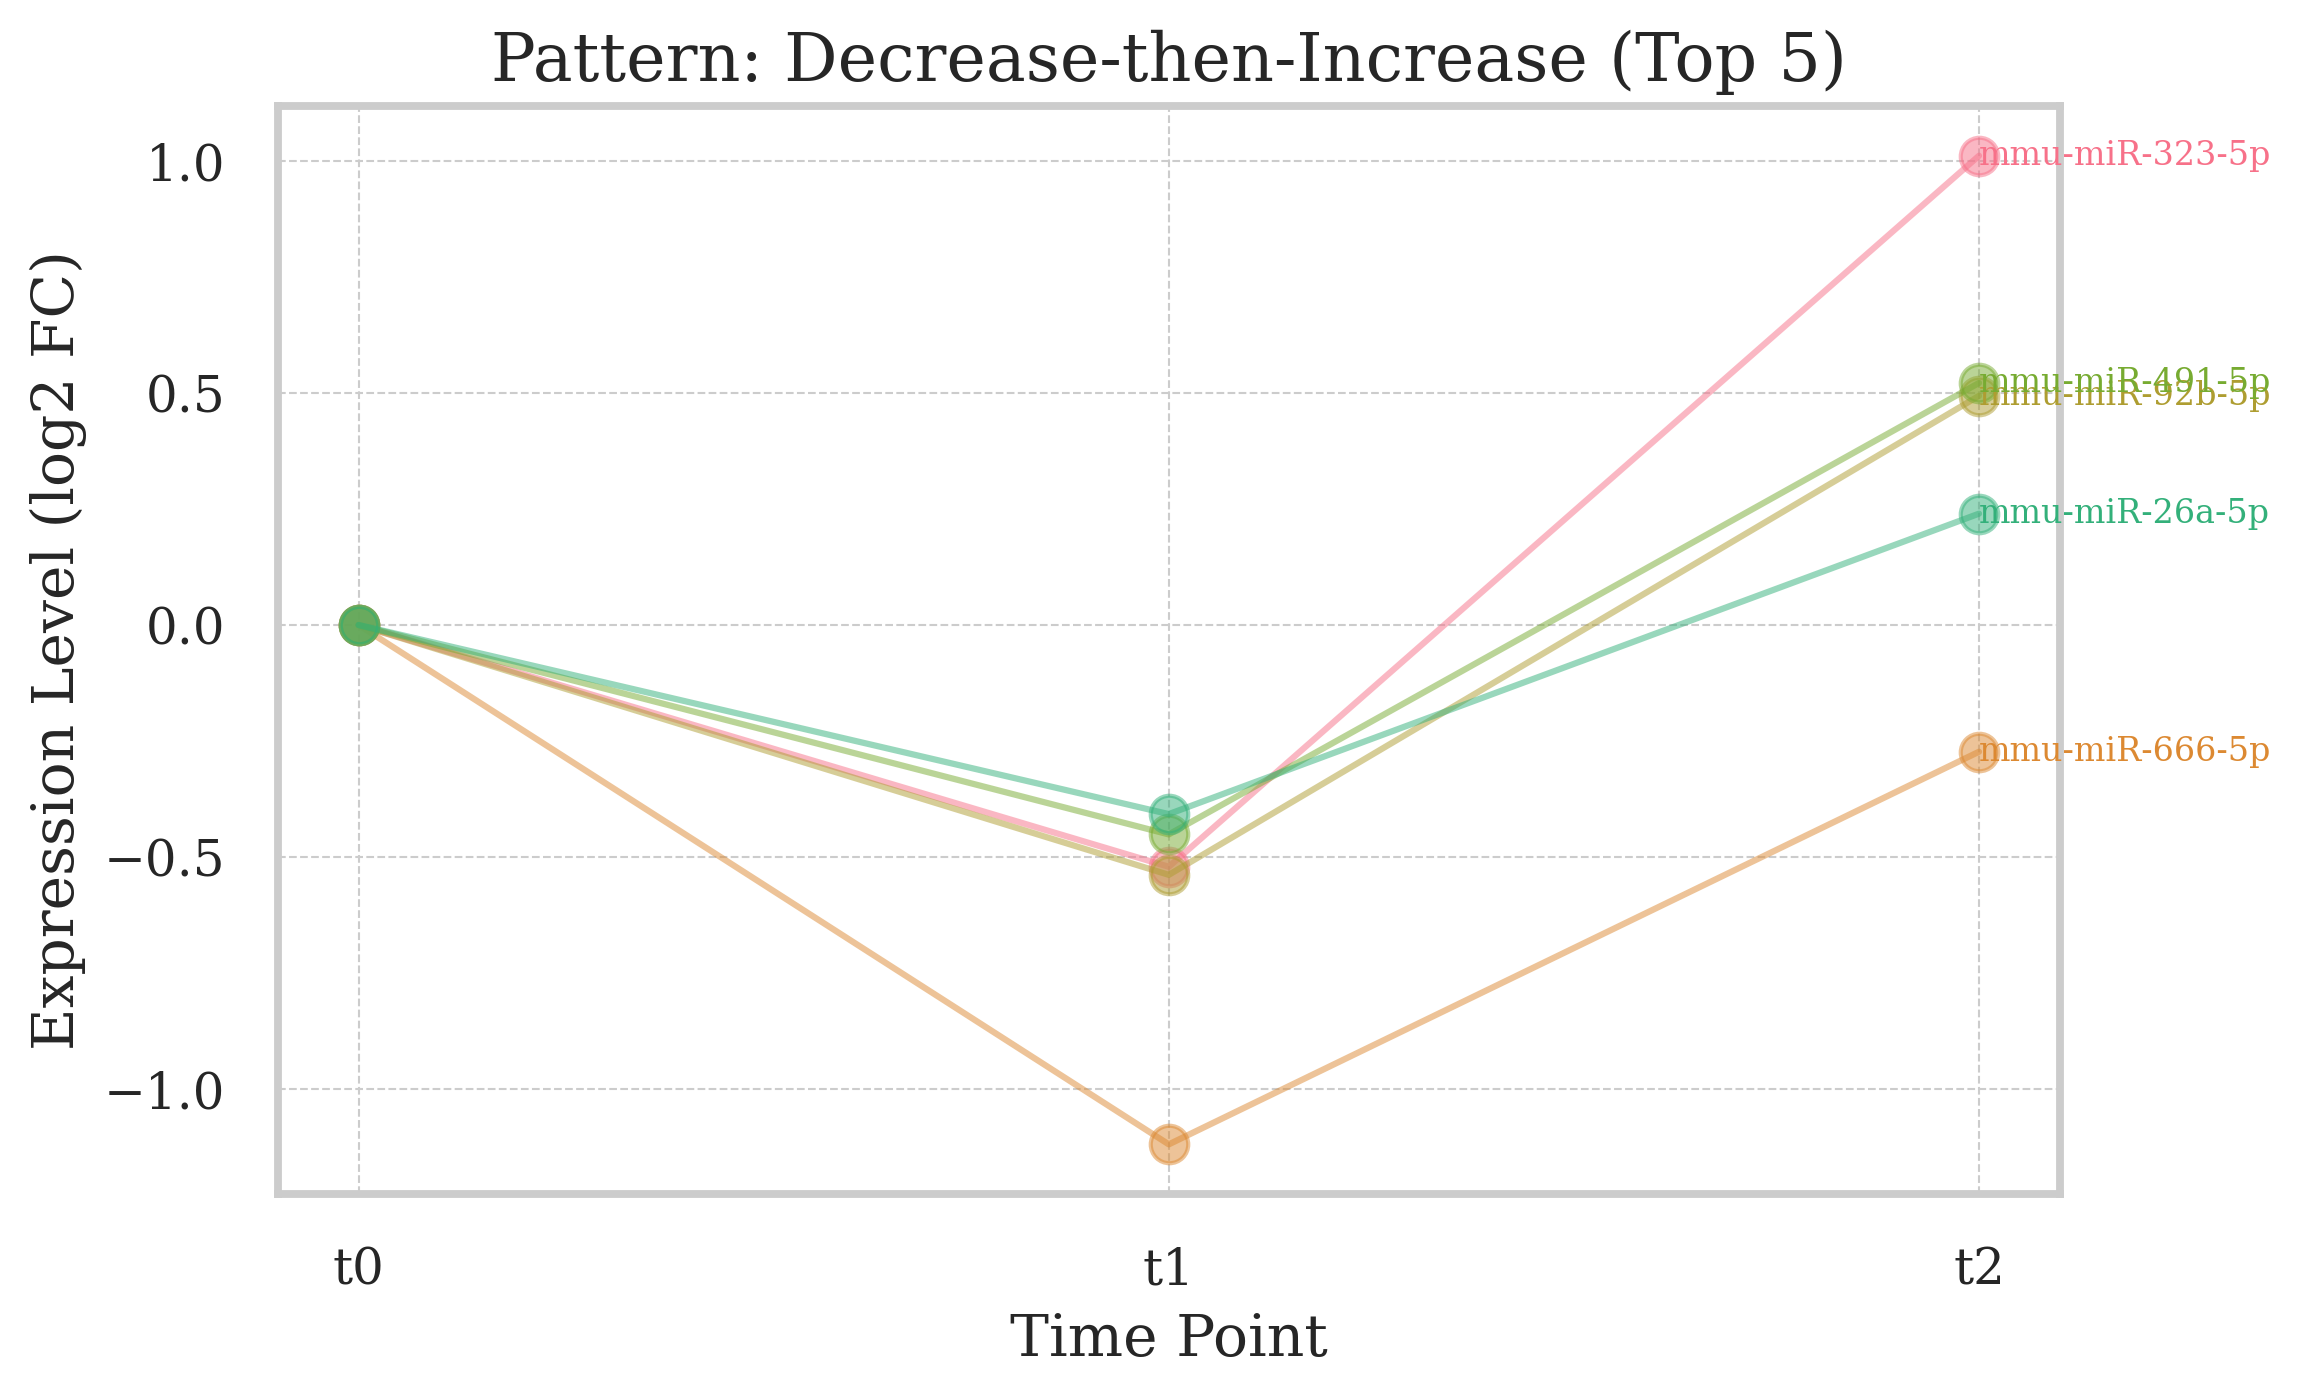

In [33]:
plot_mirna_pattern('Decrease-then-Increase', top_n=5)


# Increase-then-Decrease

In [514]:
data_r3 = pd.read_excel(path3/"Mixed_miRNA_Increase-then-Decrease.xlsx")

# Step 1: Subtract the columns row-wise and store in a new column
data_r3['expr_diff'] = data_r3['FC_6_12'] - data_r3['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r3_sorted = data_r3.sort_values(by='expr_diff', ascending=True,inplace=True)

data_r3.reset_index(drop=True, inplace=True)

data_r3

miRNA_ID     baseMean    FC_2_6   FC_6_12                 pattern  \
0     mmu-miR-5099    71.879288  0.455417 -2.086749  Increase-then-Decrease   
1    mmu-miR-33-5p   120.192203  1.003831 -1.020228  Increase-then-Decrease   
2     mmu-miR-6406   121.379169  0.755009 -1.148264  Increase-then-Decrease   
3   mmu-miR-34b-5p   138.428964  0.255814 -1.050799  Increase-then-Decrease   
4  mmu-miR-135a-5p  4347.512072  0.443316 -0.559295  Increase-then-Decrease   
5   mmu-miR-194-5p   978.256098  0.231034 -0.622241  Increase-then-Decrease   
6   mmu-miR-381-3p  1831.261967  0.240370 -0.356820  Increase-then-Decrease   

   expr_diff  
0  -2.542166  
1  -2.024059  
2  -1.903273  
3  -1.306613  
4  -1.002612  
5  -0.853275  
6  -0.597190

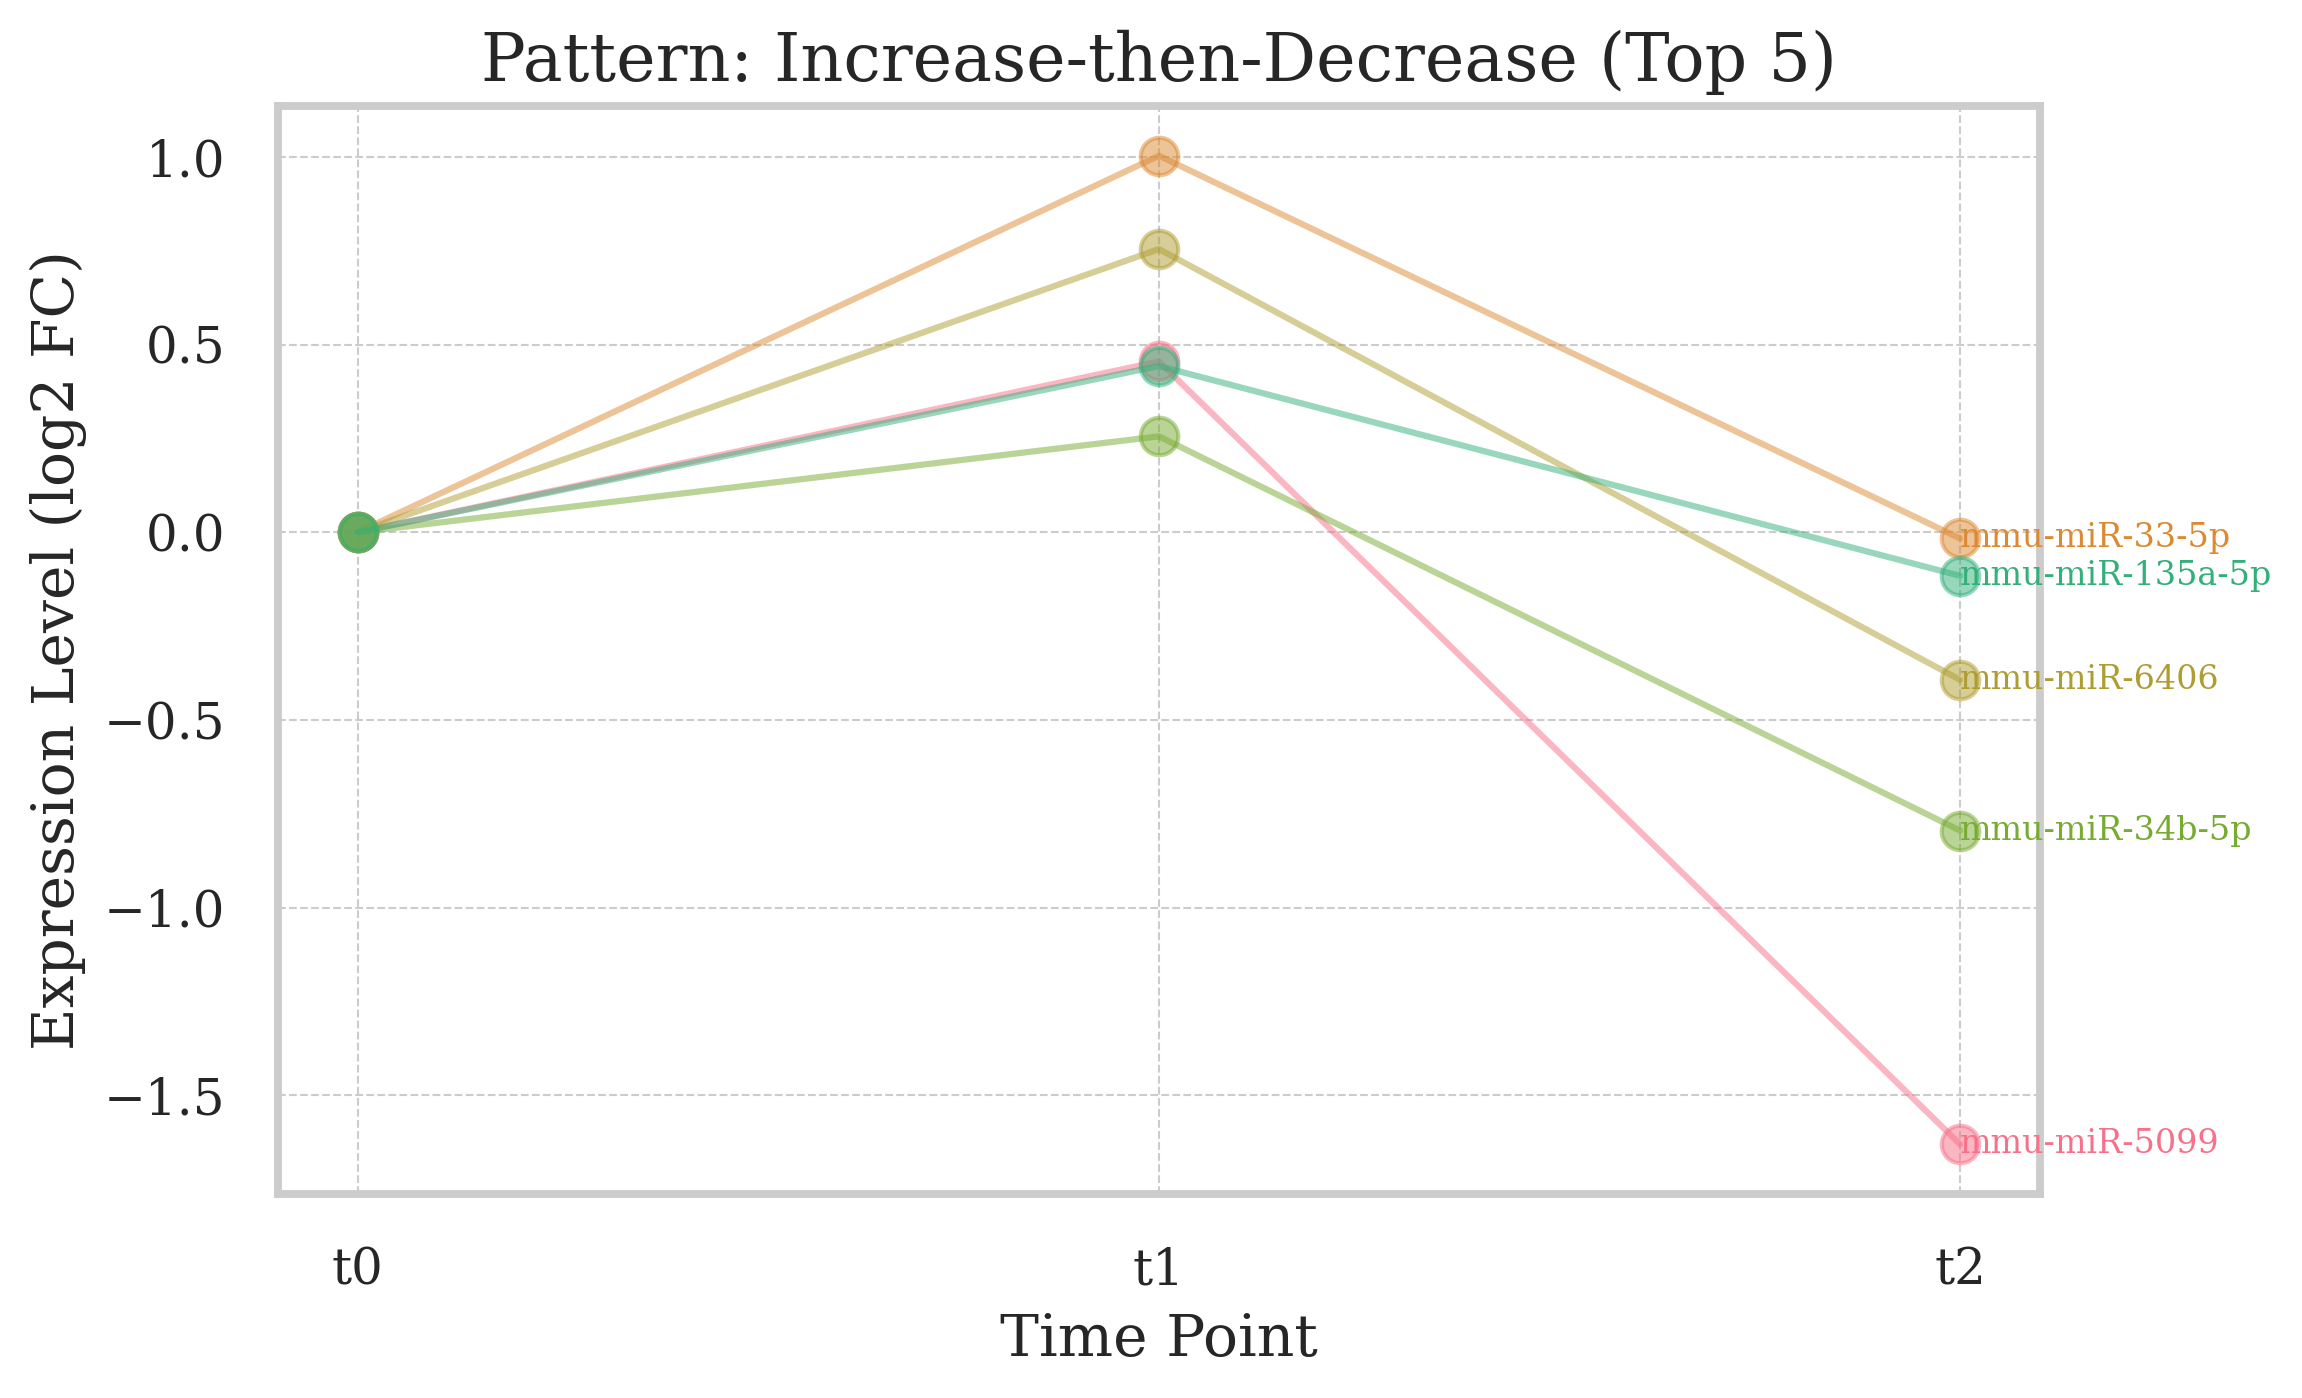

In [32]:
plot_mirna_pattern('Increase-then-Decrease', top_n=5)


# Gradual-Decrease

In [497]:
data_r4 = pd.read_excel(path3/"Mixed_miRNA_Gradual-Decrease.xlsx")

# Step 1: add the columns row-wise and store in a new column
data_r4['expr_sum'] = data_r4['FC_6_12'] + data_r4['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r4_sorted = data_r4.sort_values(by='expr_sum', ascending=True,inplace=True)

data_r4.reset_index(drop=True, inplace=True)

data_r4

miRNA_ID       baseMean    FC_2_6   FC_6_12           pattern  \
0   mmu-miR-1264-3p   14997.868751 -1.435970 -2.553652  Gradual-Decrease   
1   mmu-miR-1298-5p   16975.985098 -1.332344 -2.108564  Gradual-Decrease   
2    mmu-miR-448-3p    2293.849997 -1.389448 -1.881322  Gradual-Decrease   
3    mmu-miR-10b-5p     344.224610 -1.954425 -1.078278  Gradual-Decrease   
4   mmu-miR-1298-3p    1072.460366 -1.344444 -1.186487  Gradual-Decrease   
5    mmu-miR-363-3p      81.441188 -0.982046 -1.453689  Gradual-Decrease   
6   mmu-miR-1264-5p     435.847787 -1.331243 -1.037213  Gradual-Decrease   
7    mmu-miR-20a-3p     116.166191 -0.561848 -1.780963  Gradual-Decrease   
8   mmu-miR-126b-5p     247.822457 -0.453977 -1.499671  Gradual-Decrease   
9   mmu-miR-467a-5p    1613.782178 -0.964038 -0.907717  Gradual-Decrease   
10  mmu-miR-199a-5p     401.706747 -0.281142 -1.462391  Gradual-Decrease   
11   mmu-miR-100-5p   95661.417061 -0.825334 -0.897539  Gradual-Decrease   
12  mmu-miR-450a-5p     616.401537 -0.785078 -0.931571  Gradual-Decrease   
13   mmu-miR-409-5p    5334.572638 -0.722926 -0.987302  Gradual-Decrease   
14   mmu-miR-501-3p    1351.536146 -0.588195 -1.096728  Gradual-Decrease   
15   mmu-miR-99a-5p  457606.255932 -0.481329 -1.159393  Gradual-Decrease   
16   mmu-miR-34c-5p   11481.218225 -0.950259 -0.683349  Gradual-Decrease   
17   mmu-miR-325-3p    3701.687706 -0.473450 -1.081349  Gradual-Decrease   
18   mmu-miR-204-5p   48938.390249 -0.724089 -0.647708  Gradual-Decrease   
19   mmu-miR-152-3p    6851.835081 -0.613599 -0.724151  Gradual-Decrease   
20   mmu-miR-204-3p    1013.522677 -0.617762 -0.683519  Gradual-Decrease   
21   mmu-miR-338-5p    5738.210869 -0.220389 -1.003156  Gradual-Decrease   
22   mmu-miR-127-3p  188999.903804 -0.344812 -0.709450  Gradual-Decrease   
23      mmu-miR-484    3002.668938 -0.509422 -0.406089  Gradual-Decrease   
24   mmu-miR-30d-5p   19971.183294 -0.251549 -0.606745  Gradual-Decrease   
25   mmu-miR-362-5p    1310.960964 -0.237057 -0.552370  Gradual-Decrease   
26   mmu-miR-124-3p  698578.641117 -0.220569 -0.520759  Gradual-Decrease   

    expr_sum  
0  -3.989622  
1  -3.440908  
2  -3.270771  
3  -3.032703  
4  -2.530931  
5  -2.435736  
6  -2.368456  
7  -2.342811  
8  -1.953647  
9  -1.871755  
10 -1.743533  
11 -1.722873  
12 -1.716649  
13 -1.710228  
14 -1.684923  
15 -1.640722  
16 -1.633608  
17 -1.554799  
18 -1.371796  
19 -1.337750  
20 -1.301281  
21 -1.223545  
22 -1.054262  
23 -0.915510  
24 -0.858294  
25 -0.789427  
26 -0.741328

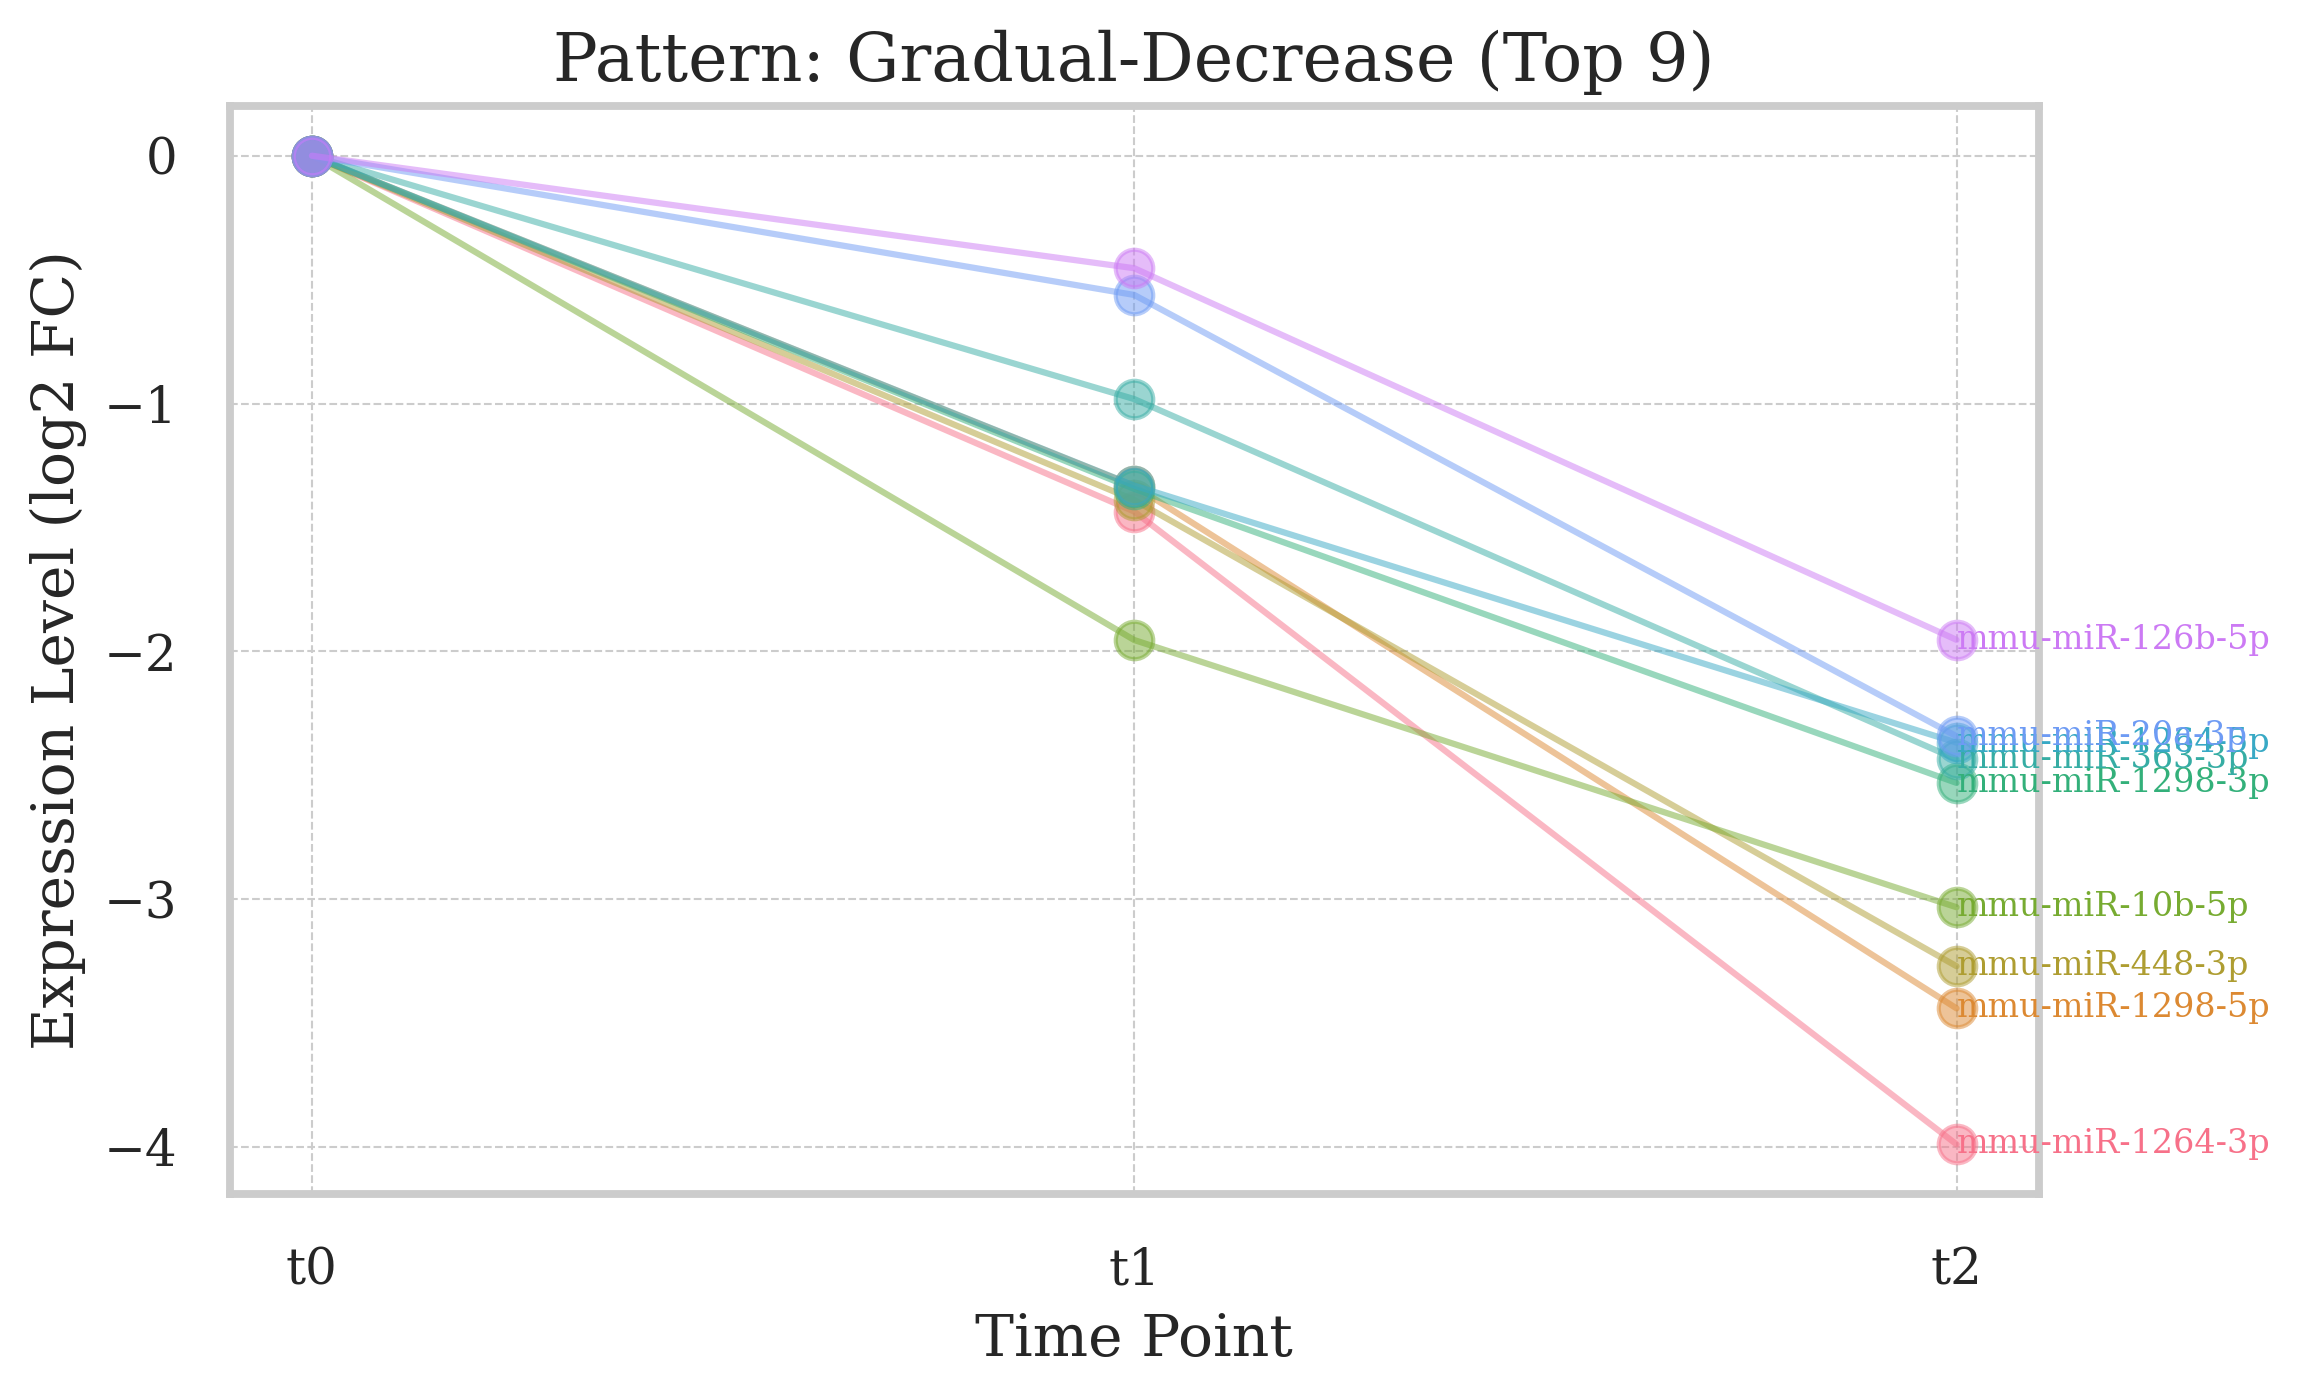

In [25]:
plot_mirna_pattern('Gradual-Decrease', top_n=9)


# Gradual-Increase

In [498]:
data_r7 = pd.read_excel(path3/"Mixed_miRNA_Gradual-Increase.xlsx")

# Step 1: add the columns row-wise and store in a new column
data_r7['expr_sum'] = data_r7['FC_6_12'] + data_r7['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r7_sorted = data_r7.sort_values(by='expr_sum', ascending=False,inplace=True)

data_r7.reset_index(drop=True, inplace=True)

data_r7

miRNA_ID      baseMean    FC_2_6   FC_6_12           pattern  \
0  mmu-miR-874-3p    754.812407  0.591251  0.902743  Gradual-Increase   
1  mmu-miR-434-3p  22556.400582  0.645608  0.444244  Gradual-Increase   
2  mmu-miR-132-3p  25327.273119  0.460537  0.604433  Gradual-Increase   
3  mmu-miR-222-3p   4798.476125  0.532404  0.519176  Gradual-Increase   
4  mmu-miR-139-5p  17305.029345  0.281032  0.580082  Gradual-Increase   
5  mmu-miR-409-3p    735.322583  0.337788  0.505171  Gradual-Increase   

   expr_sum  
0  1.493993  
1  1.089851  
2  1.064969  
3  1.051579  
4  0.861115  
5  0.842958

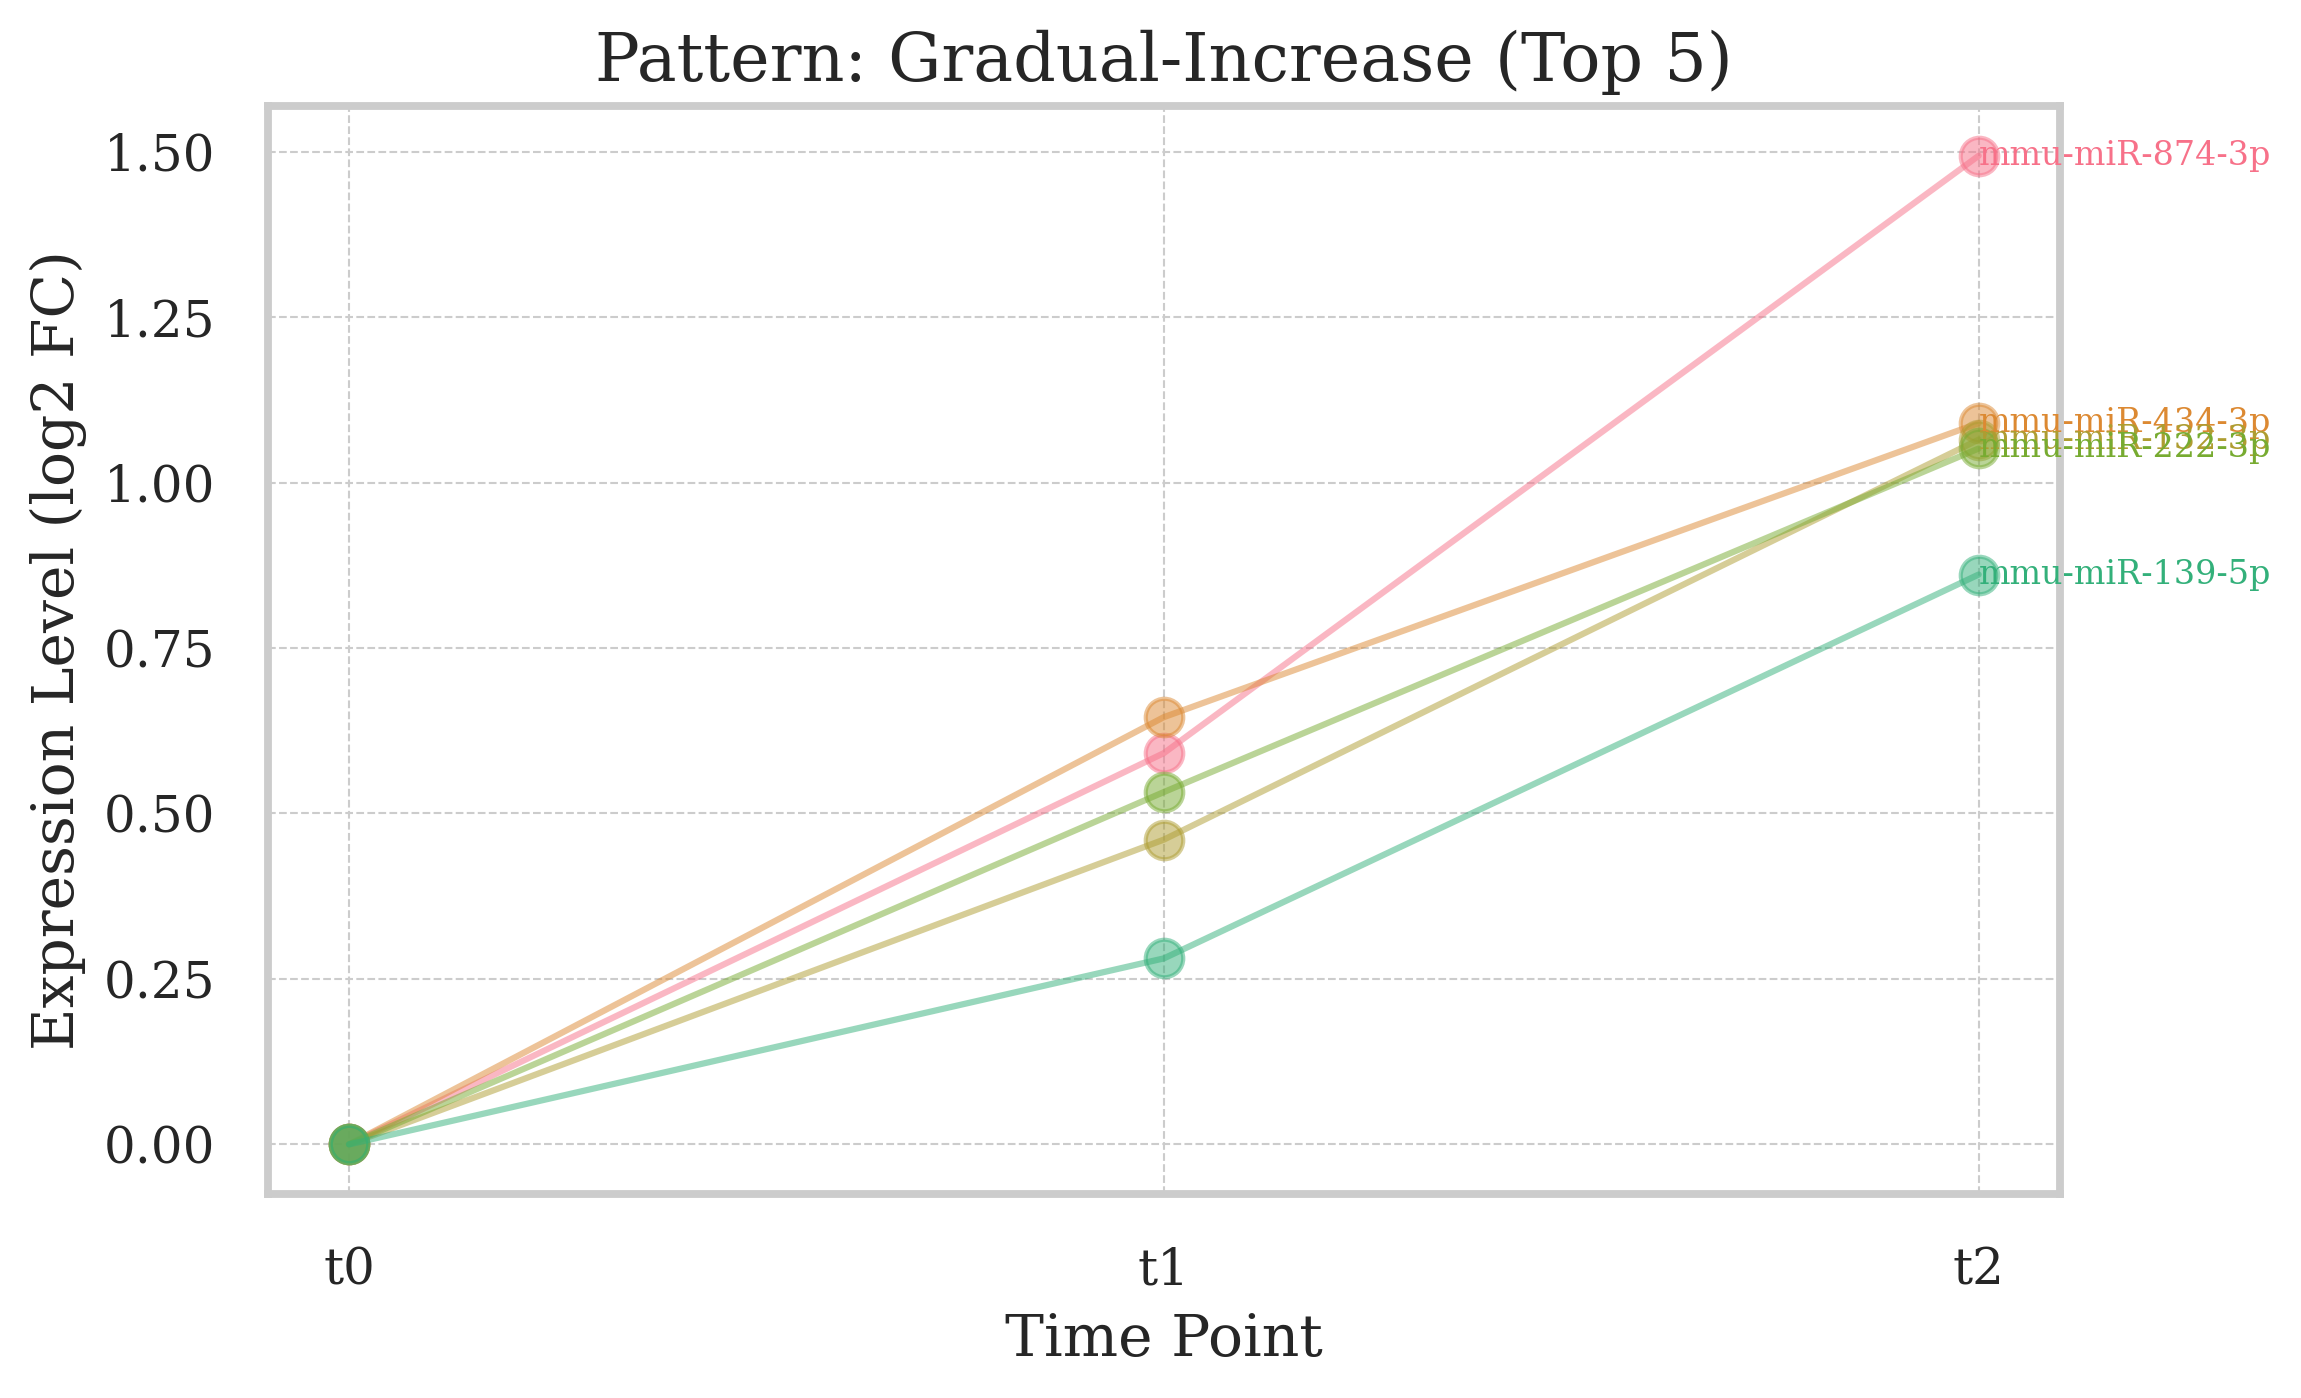

In [30]:
plot_mirna_pattern('Gradual-Increase', top_n=5)


data_r5 = pd.read_excel(path3/"Mixed_miRNA_Unclassified.xlsx")

data_r5

# All the plots

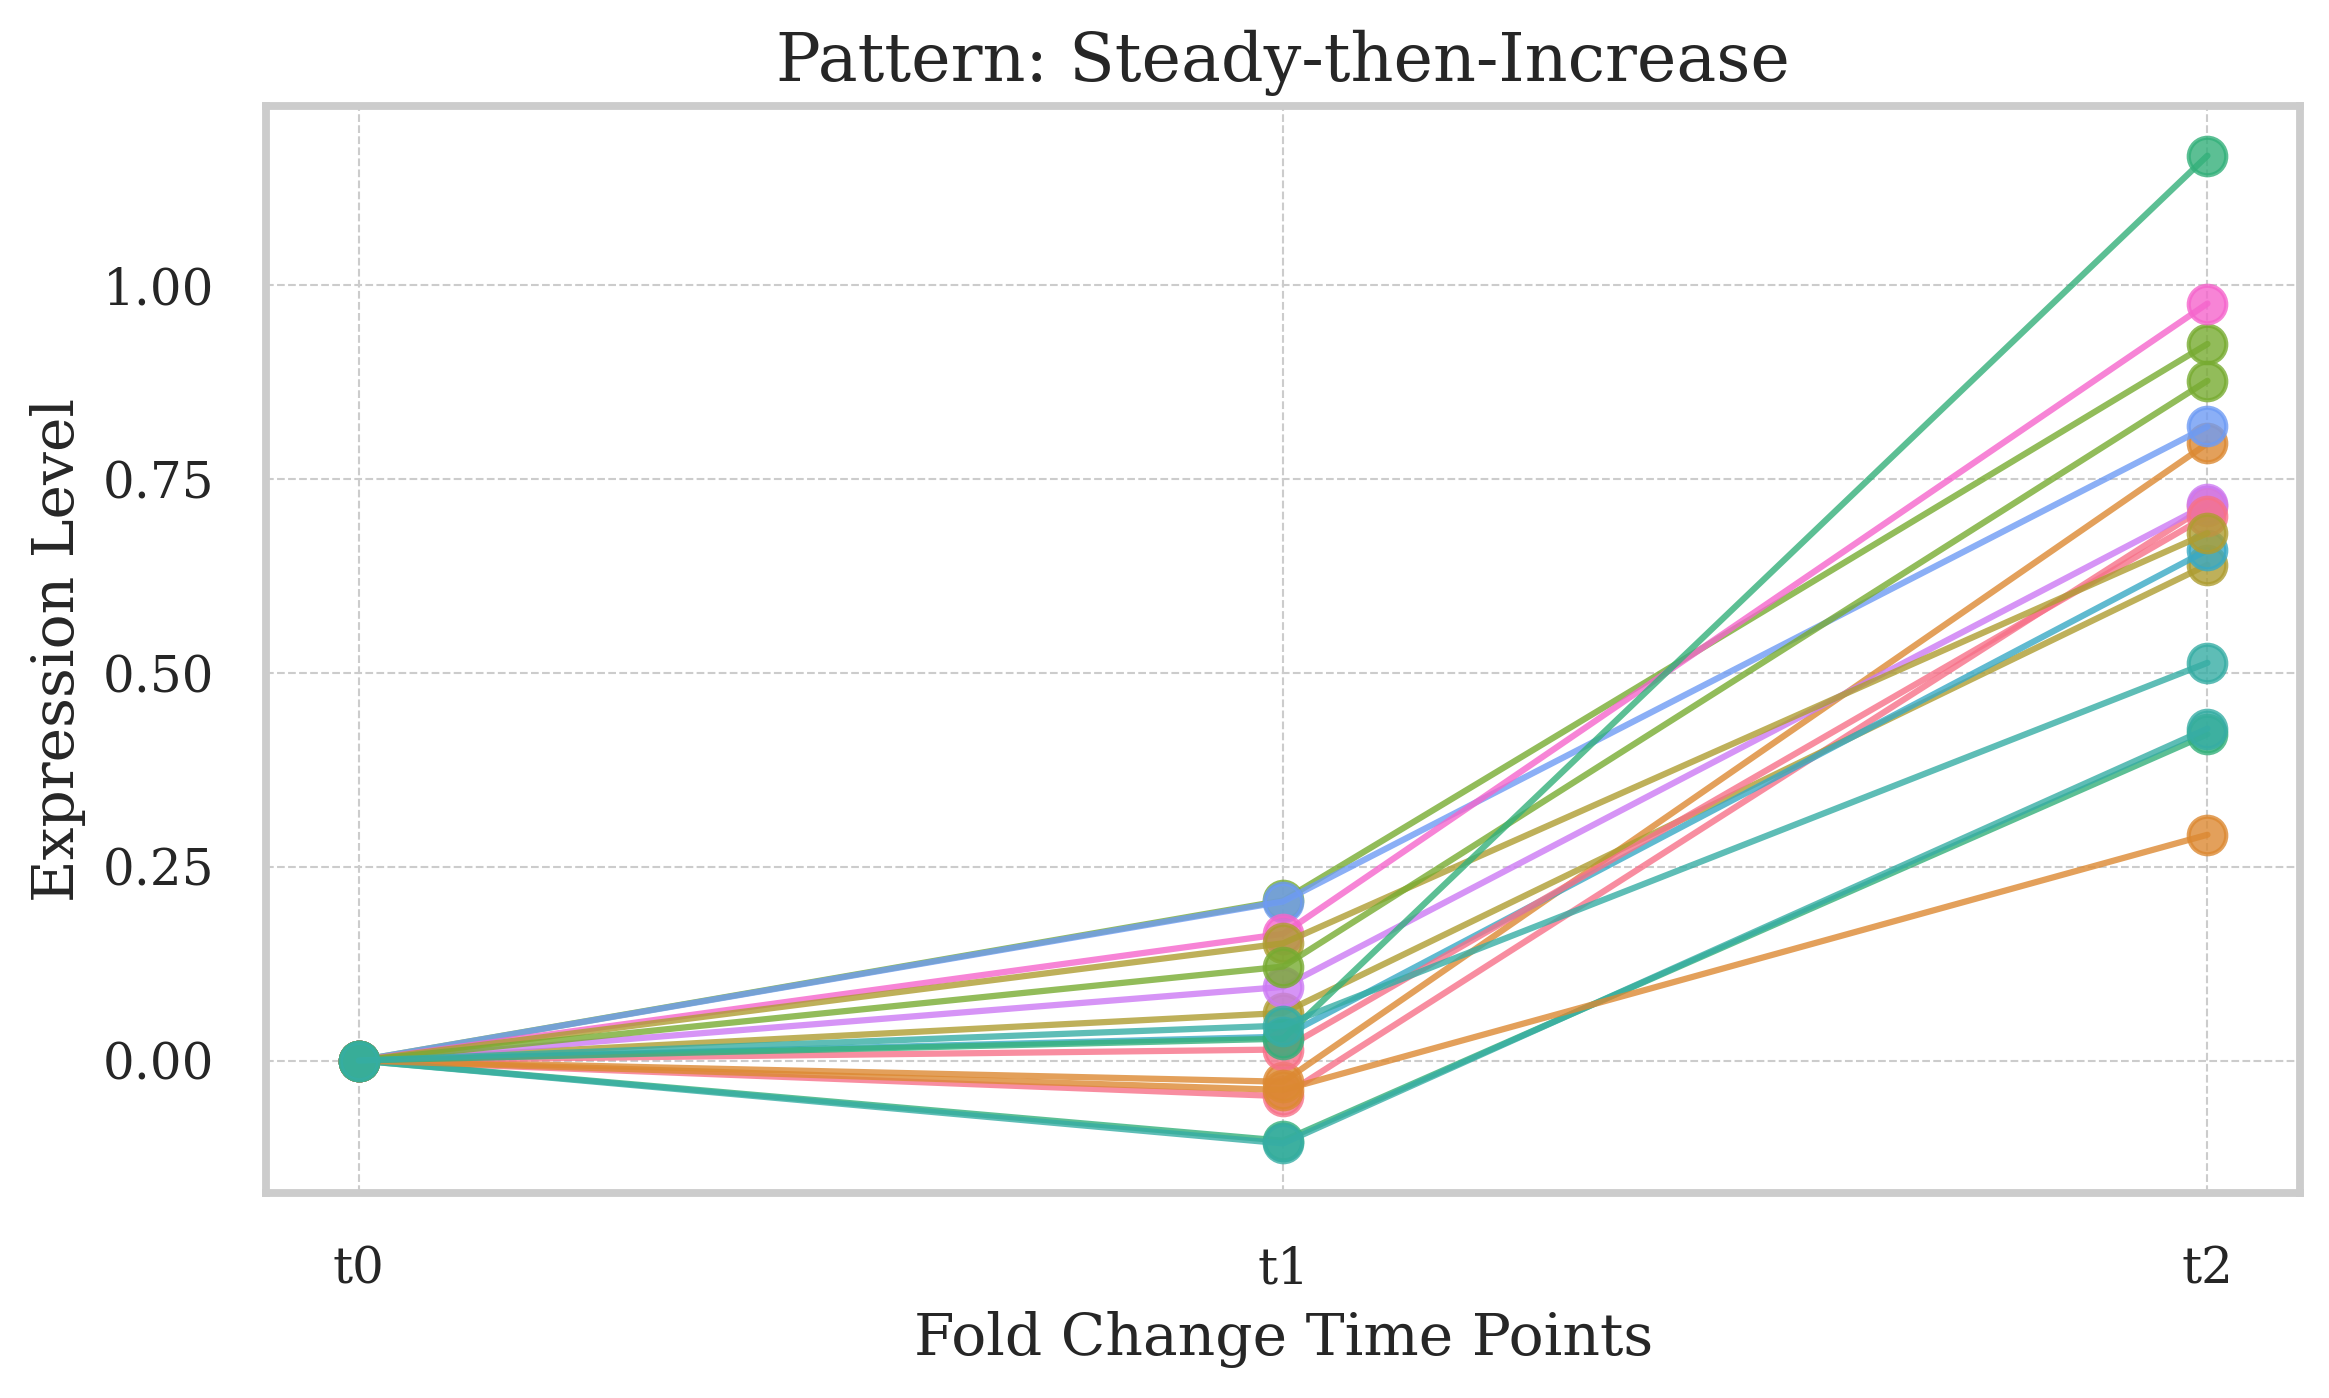

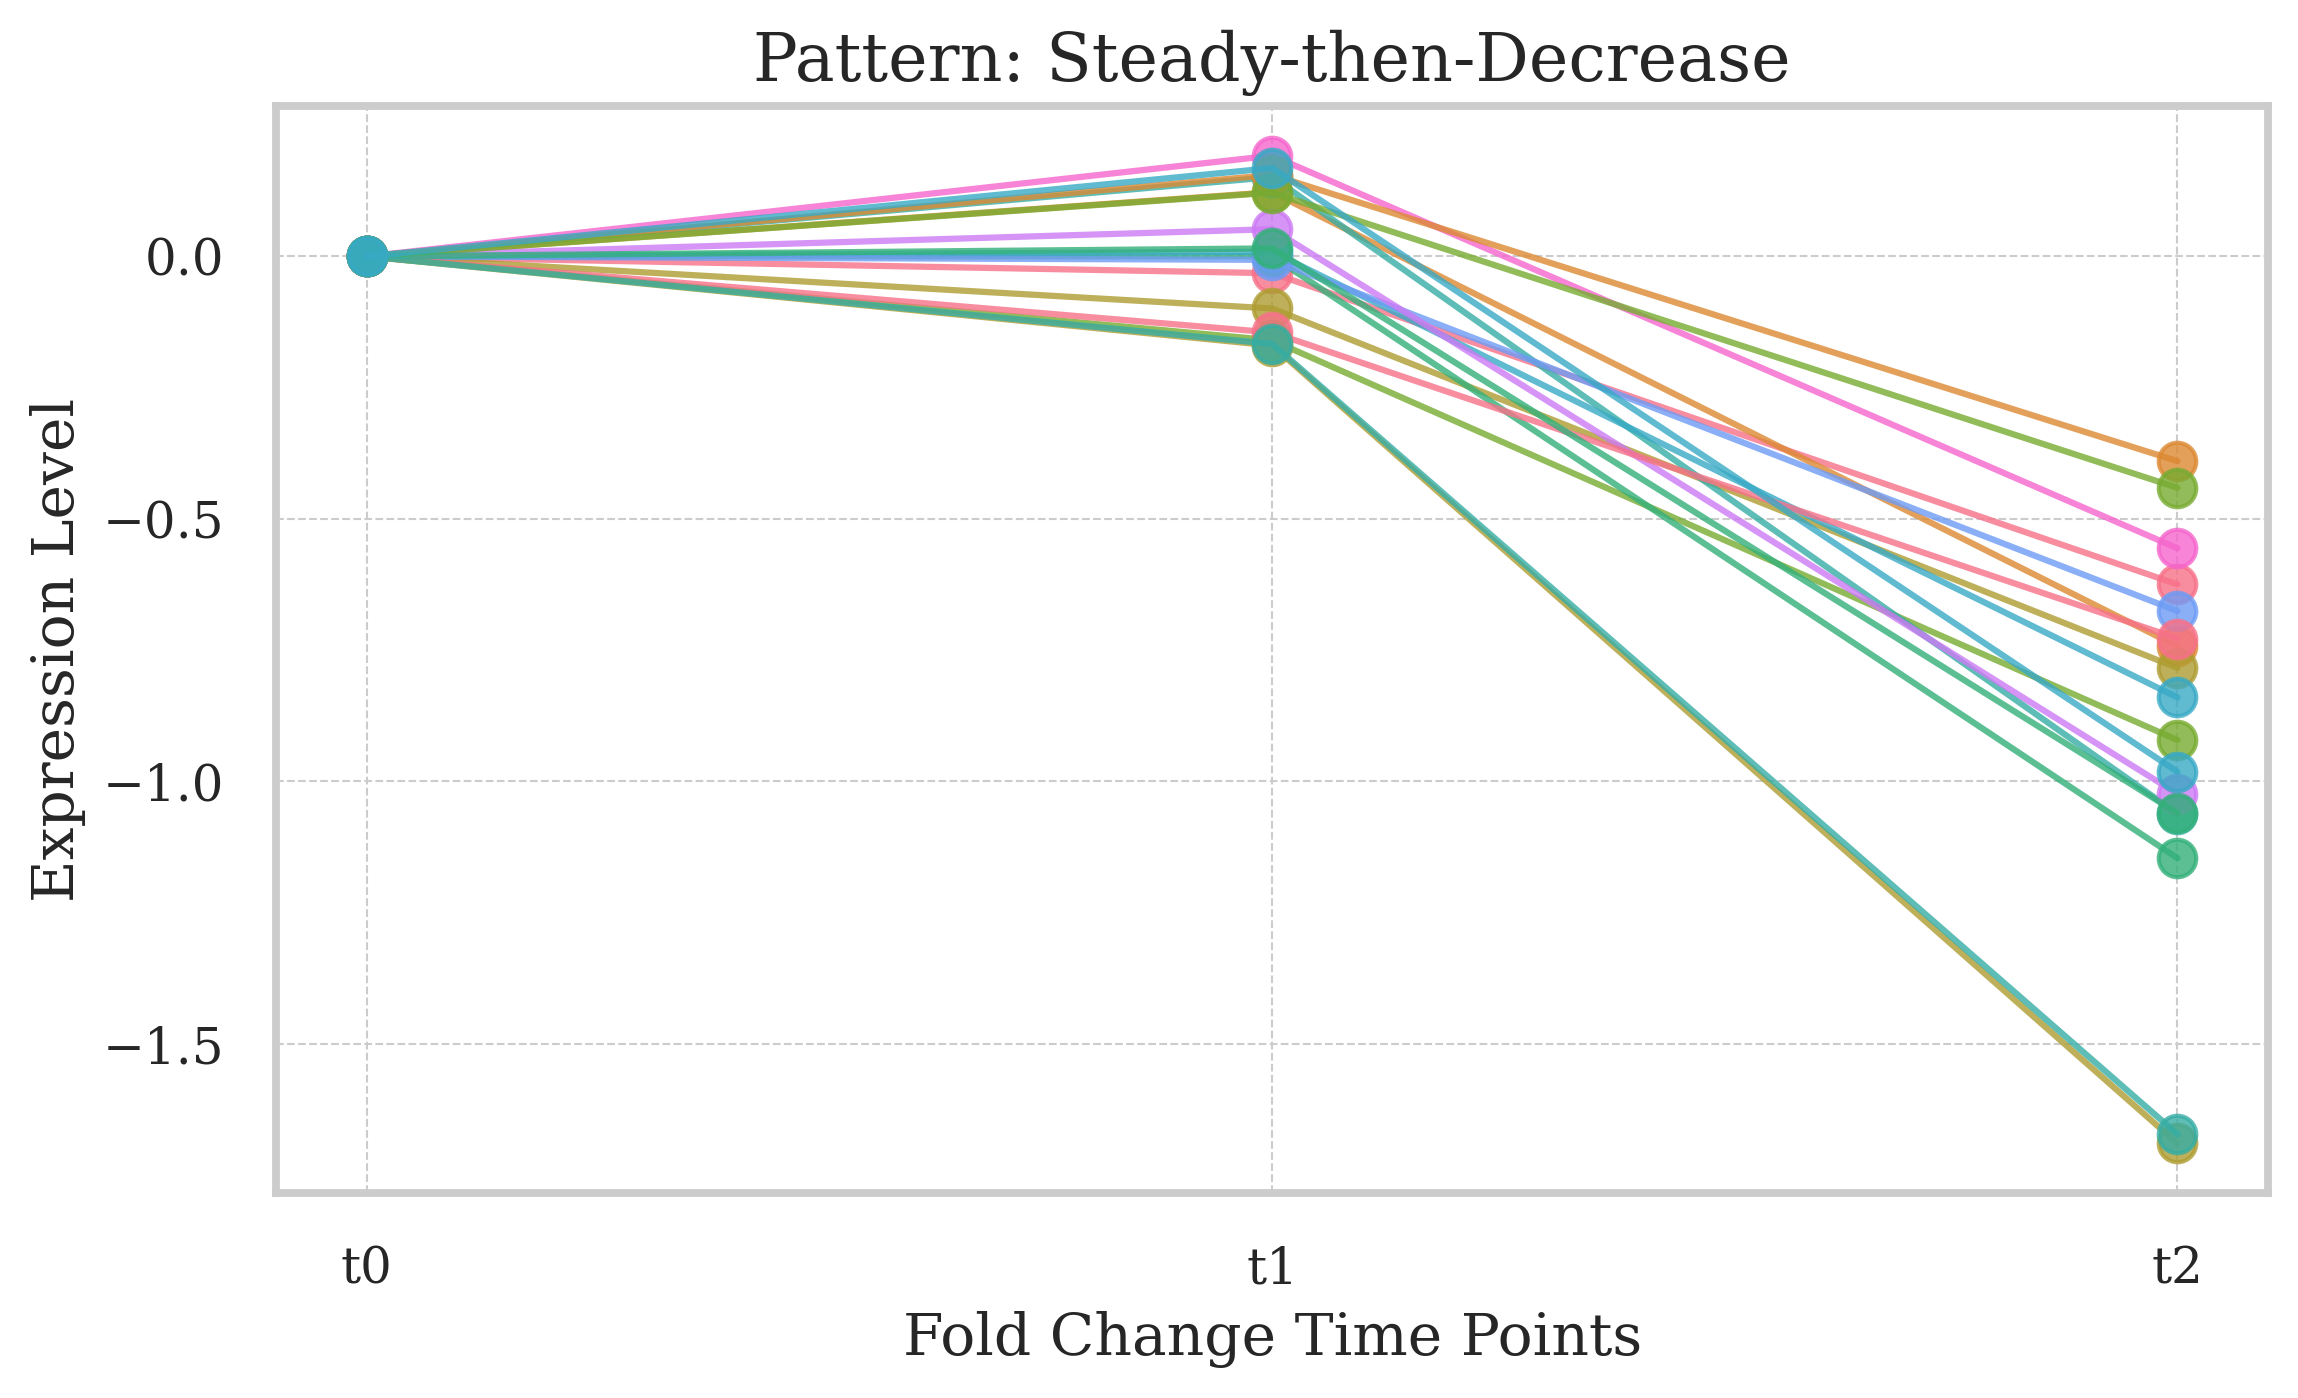

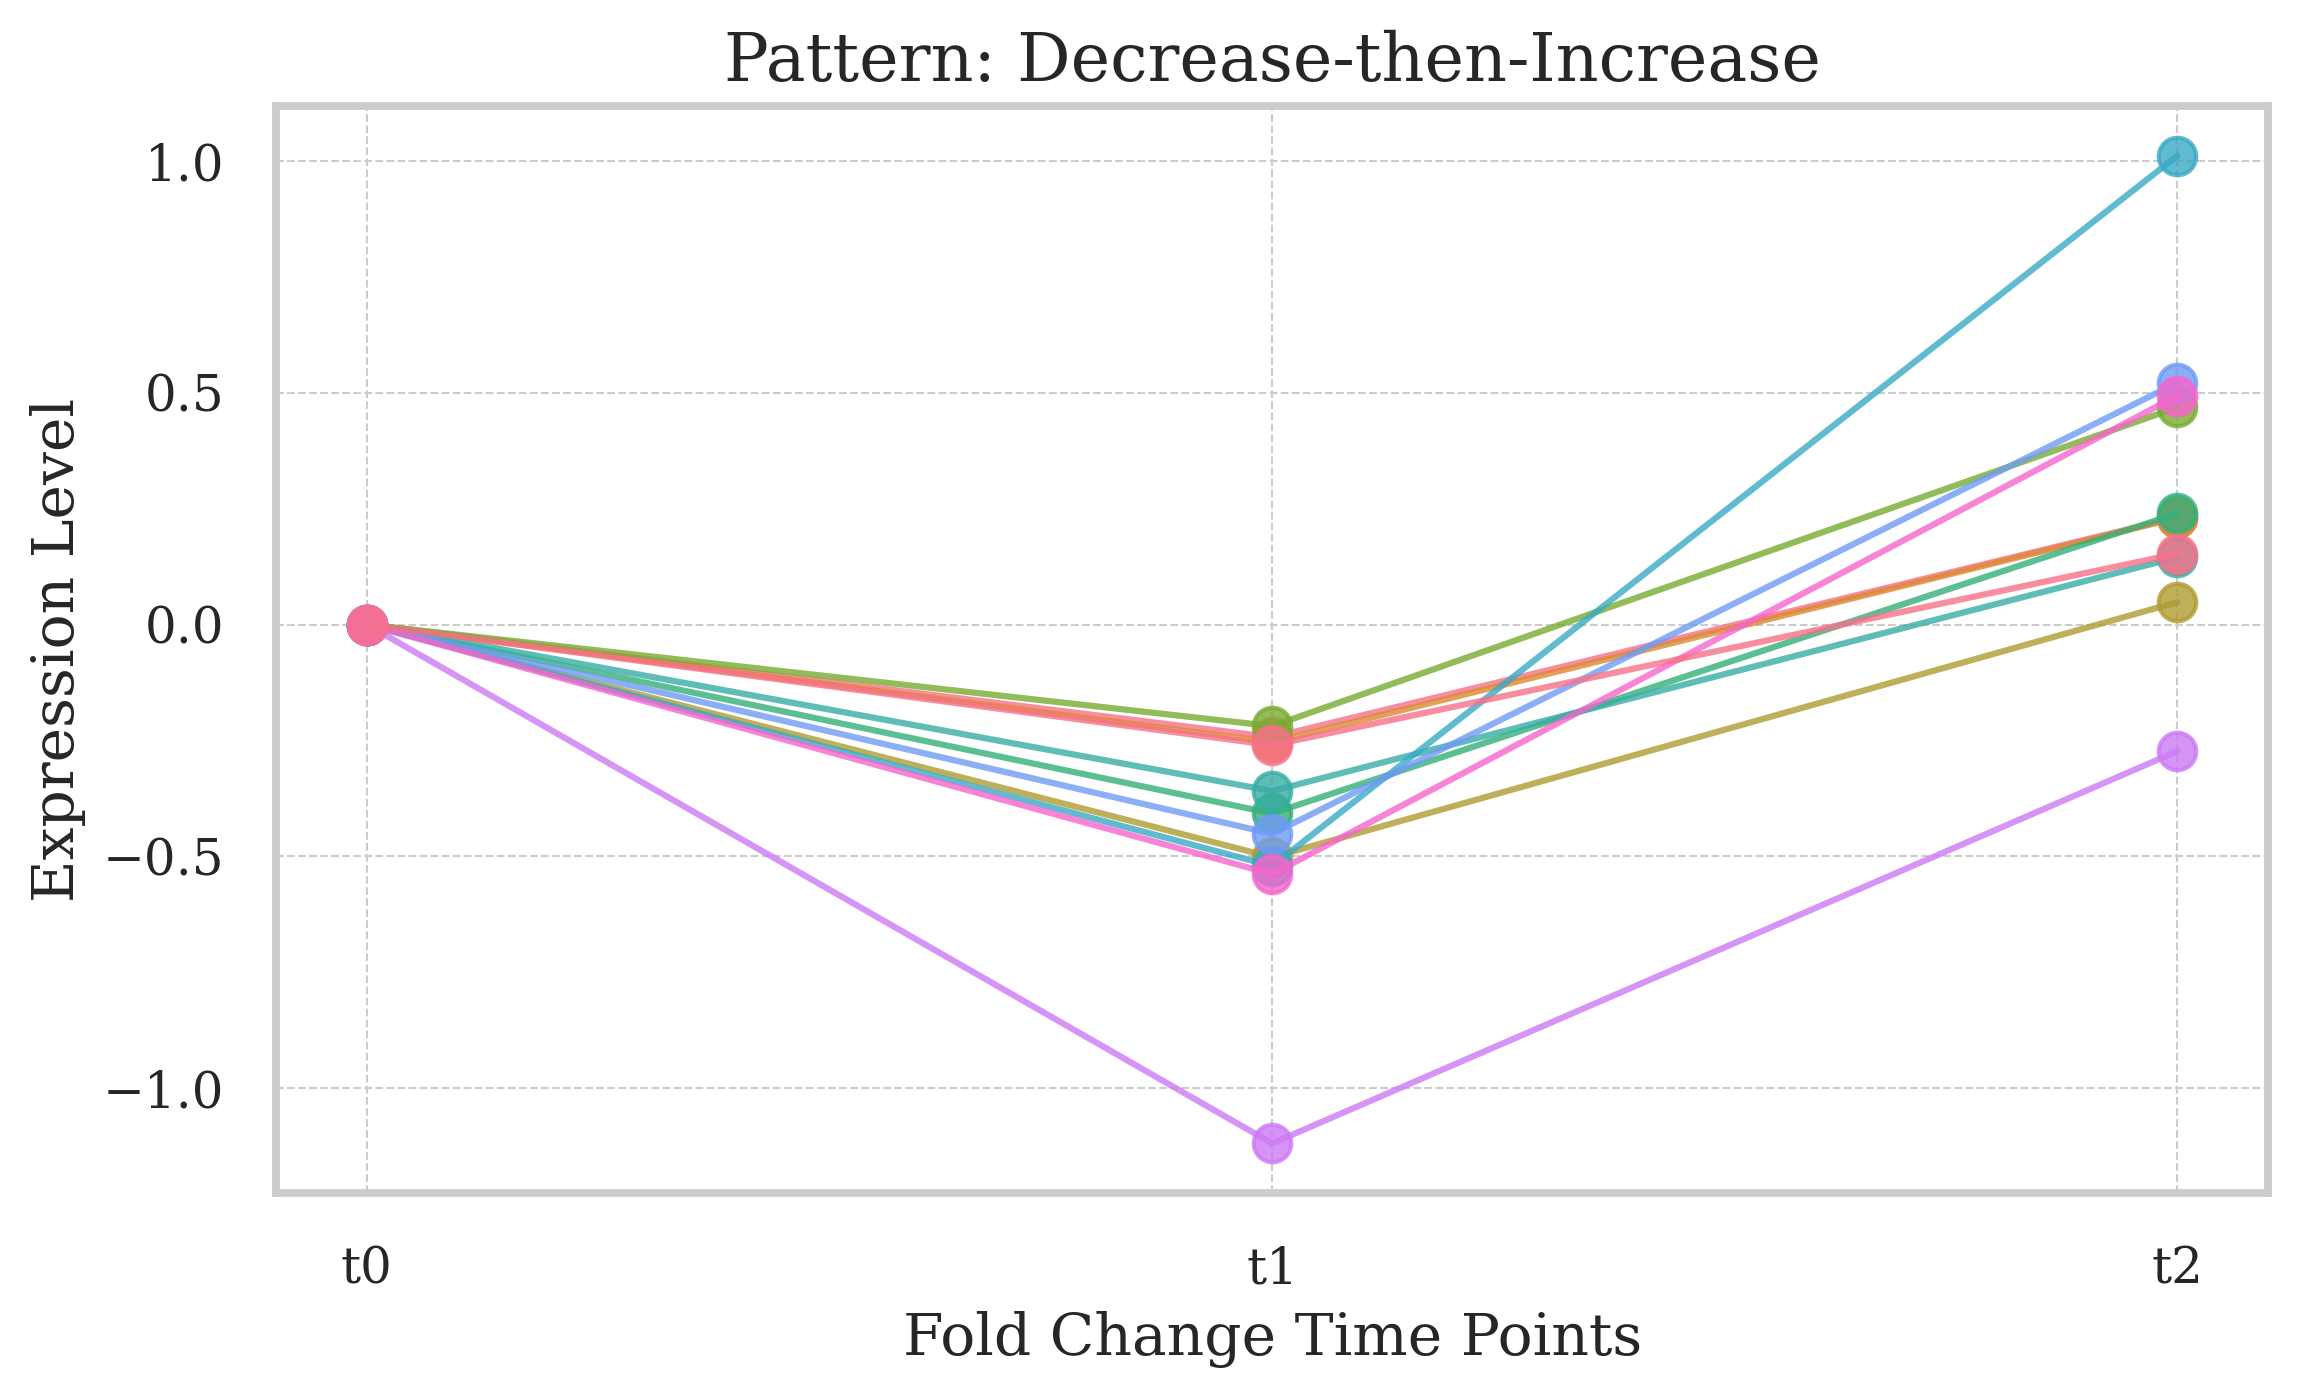

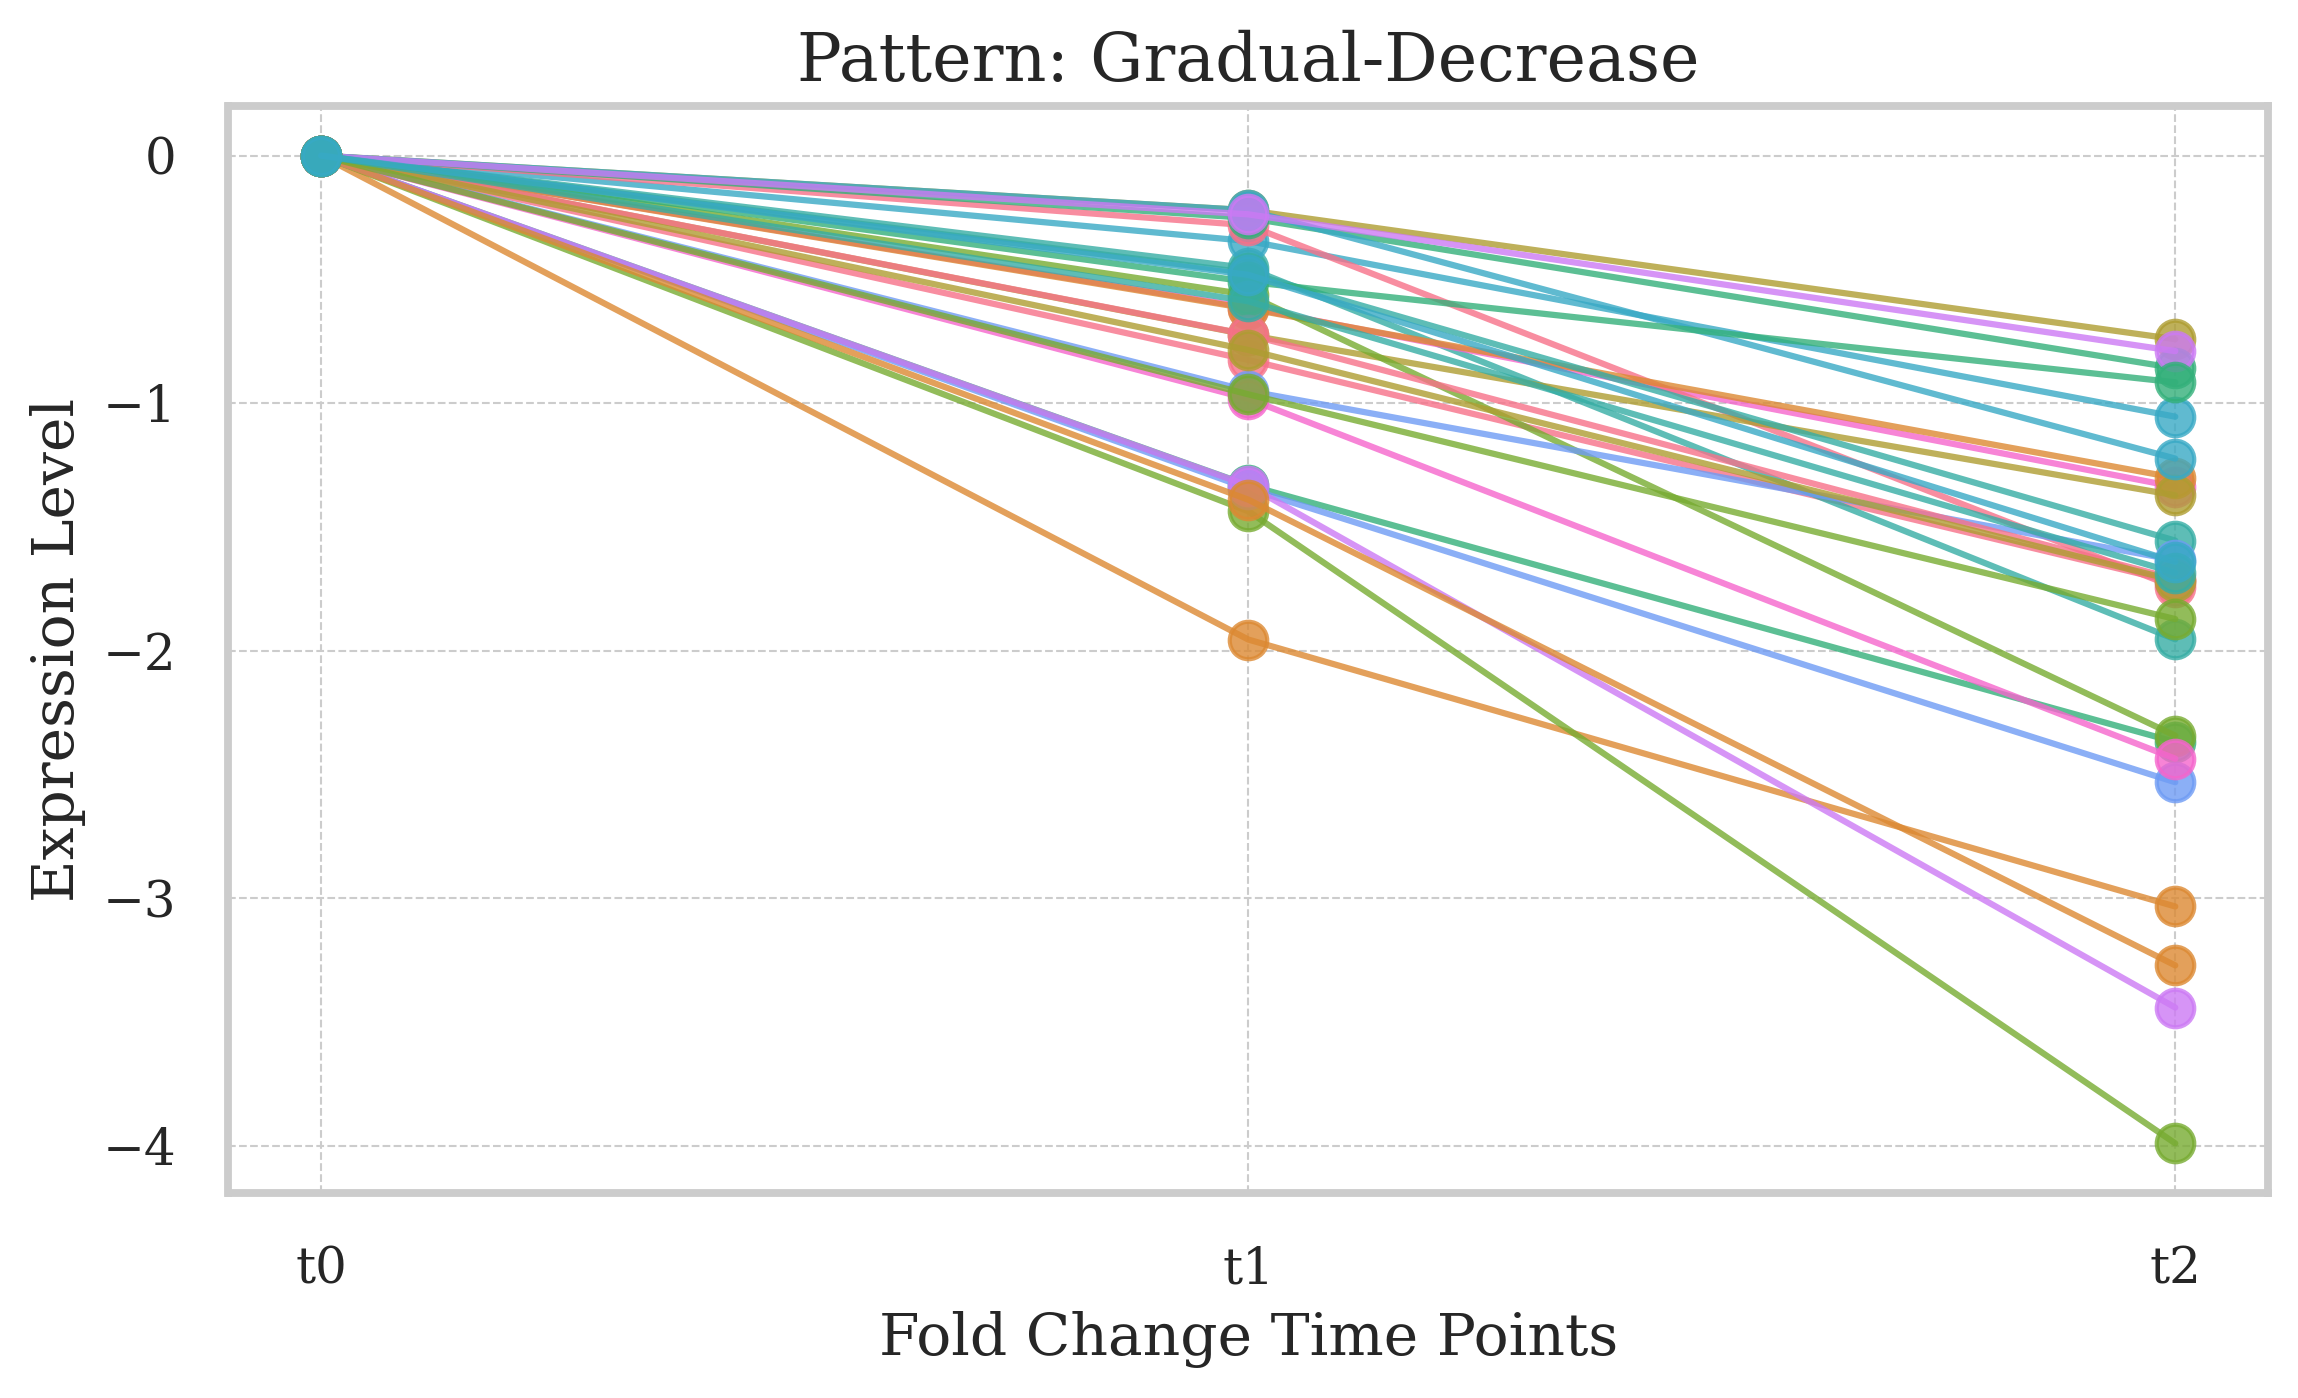

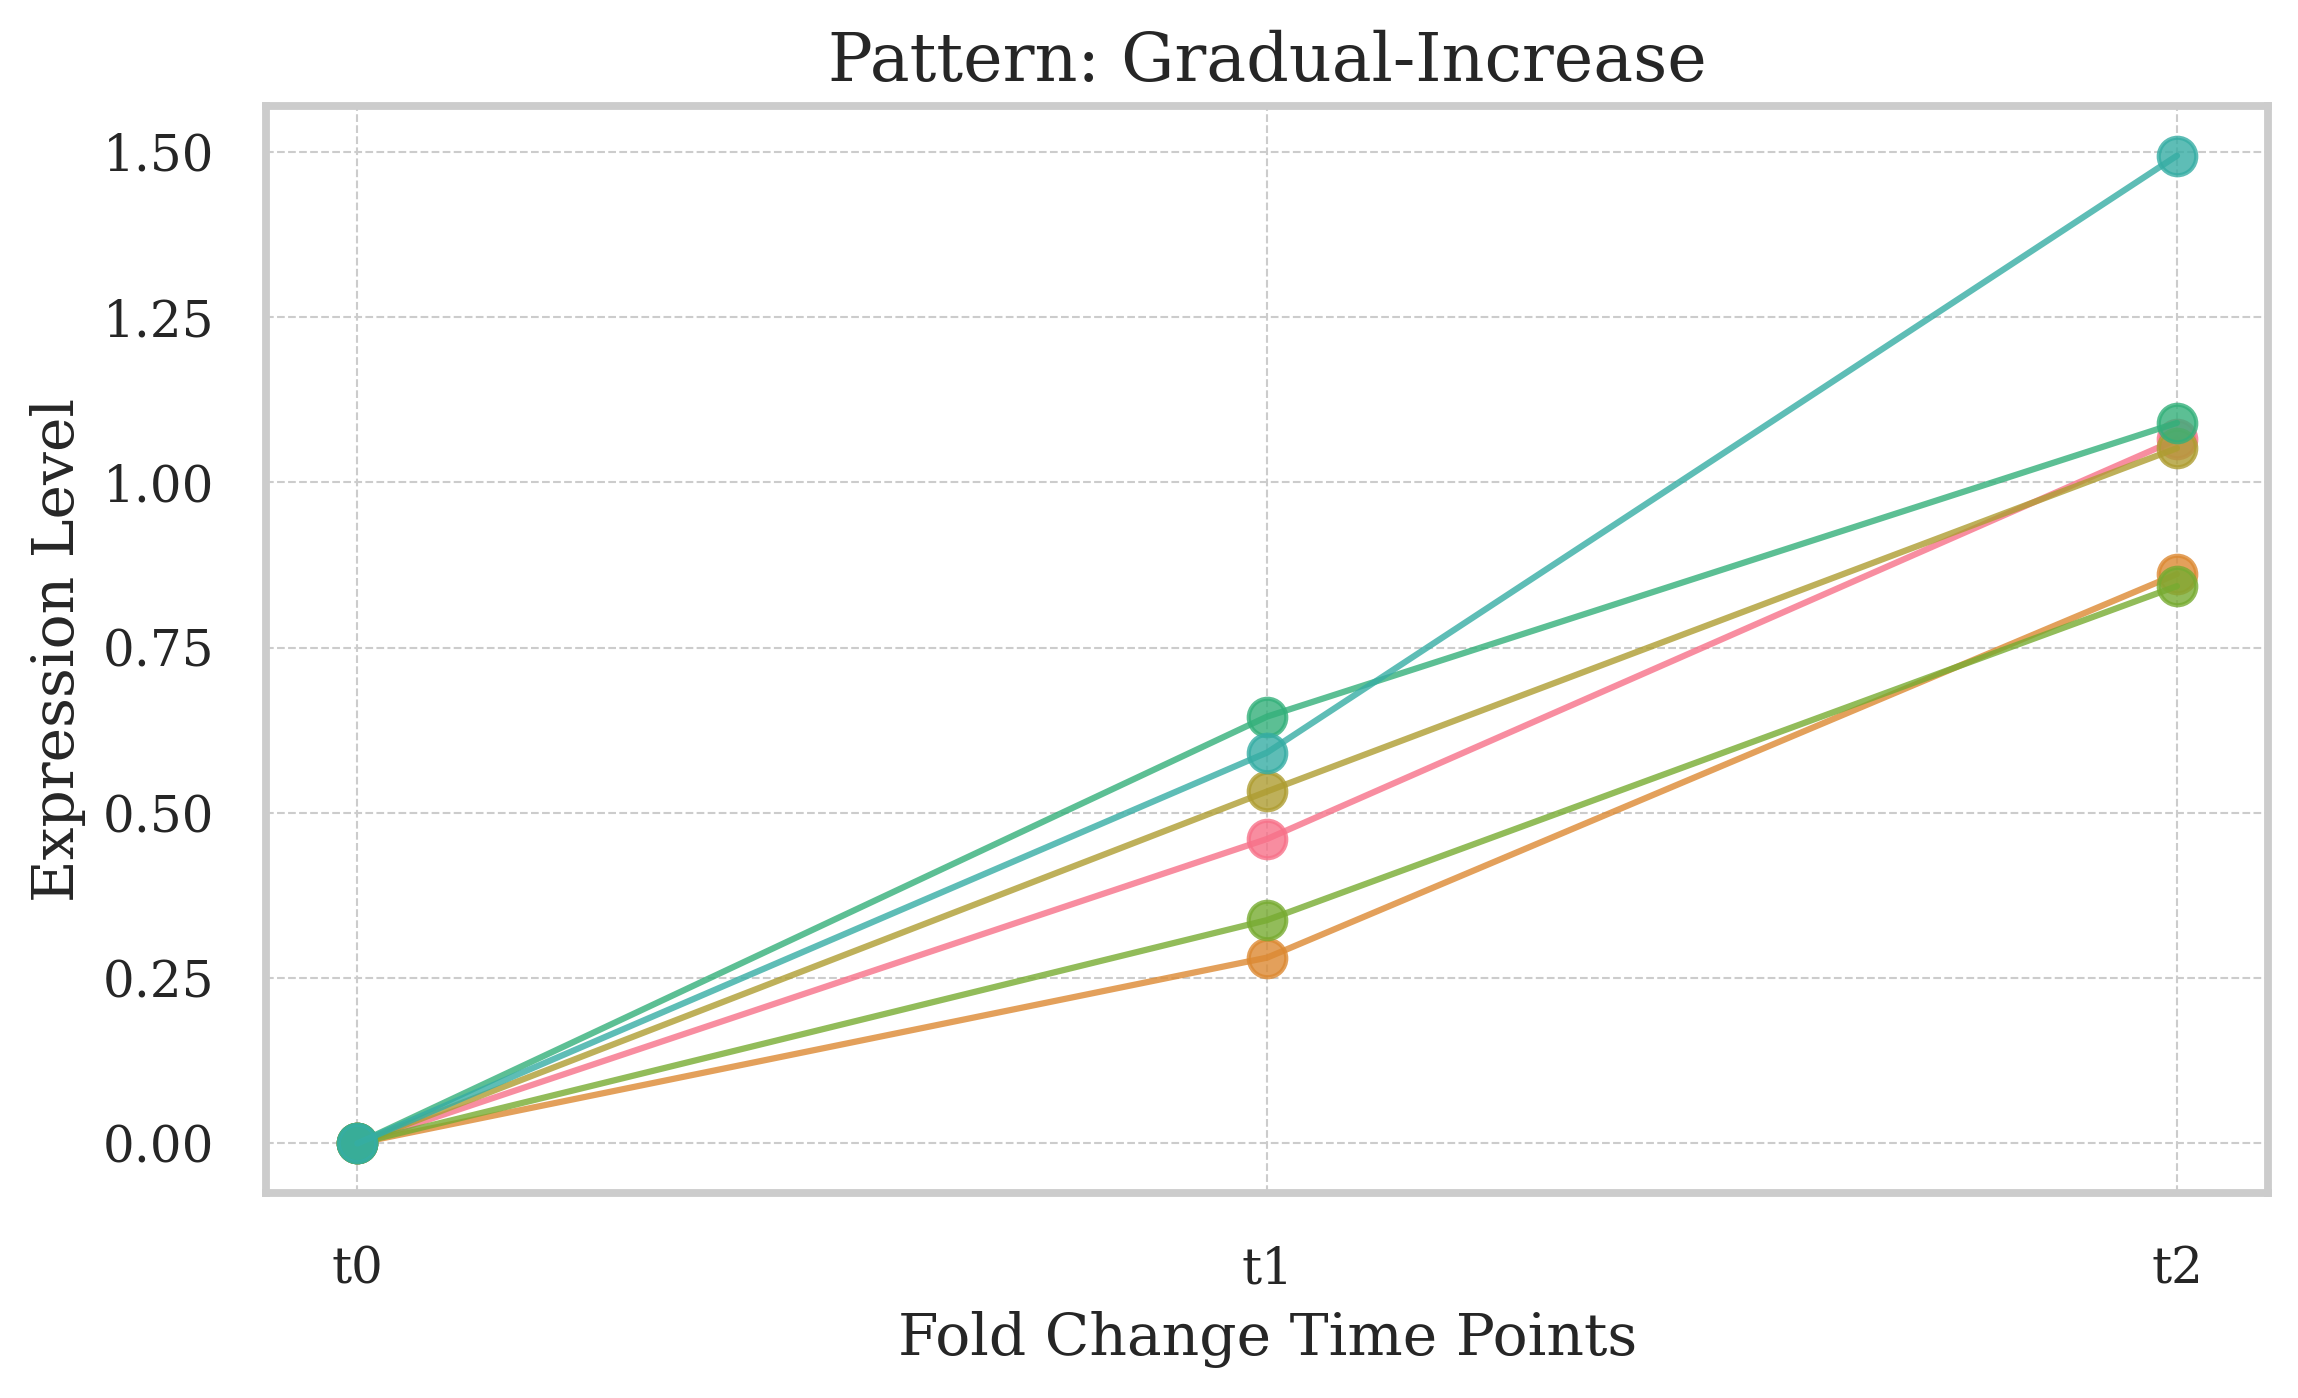

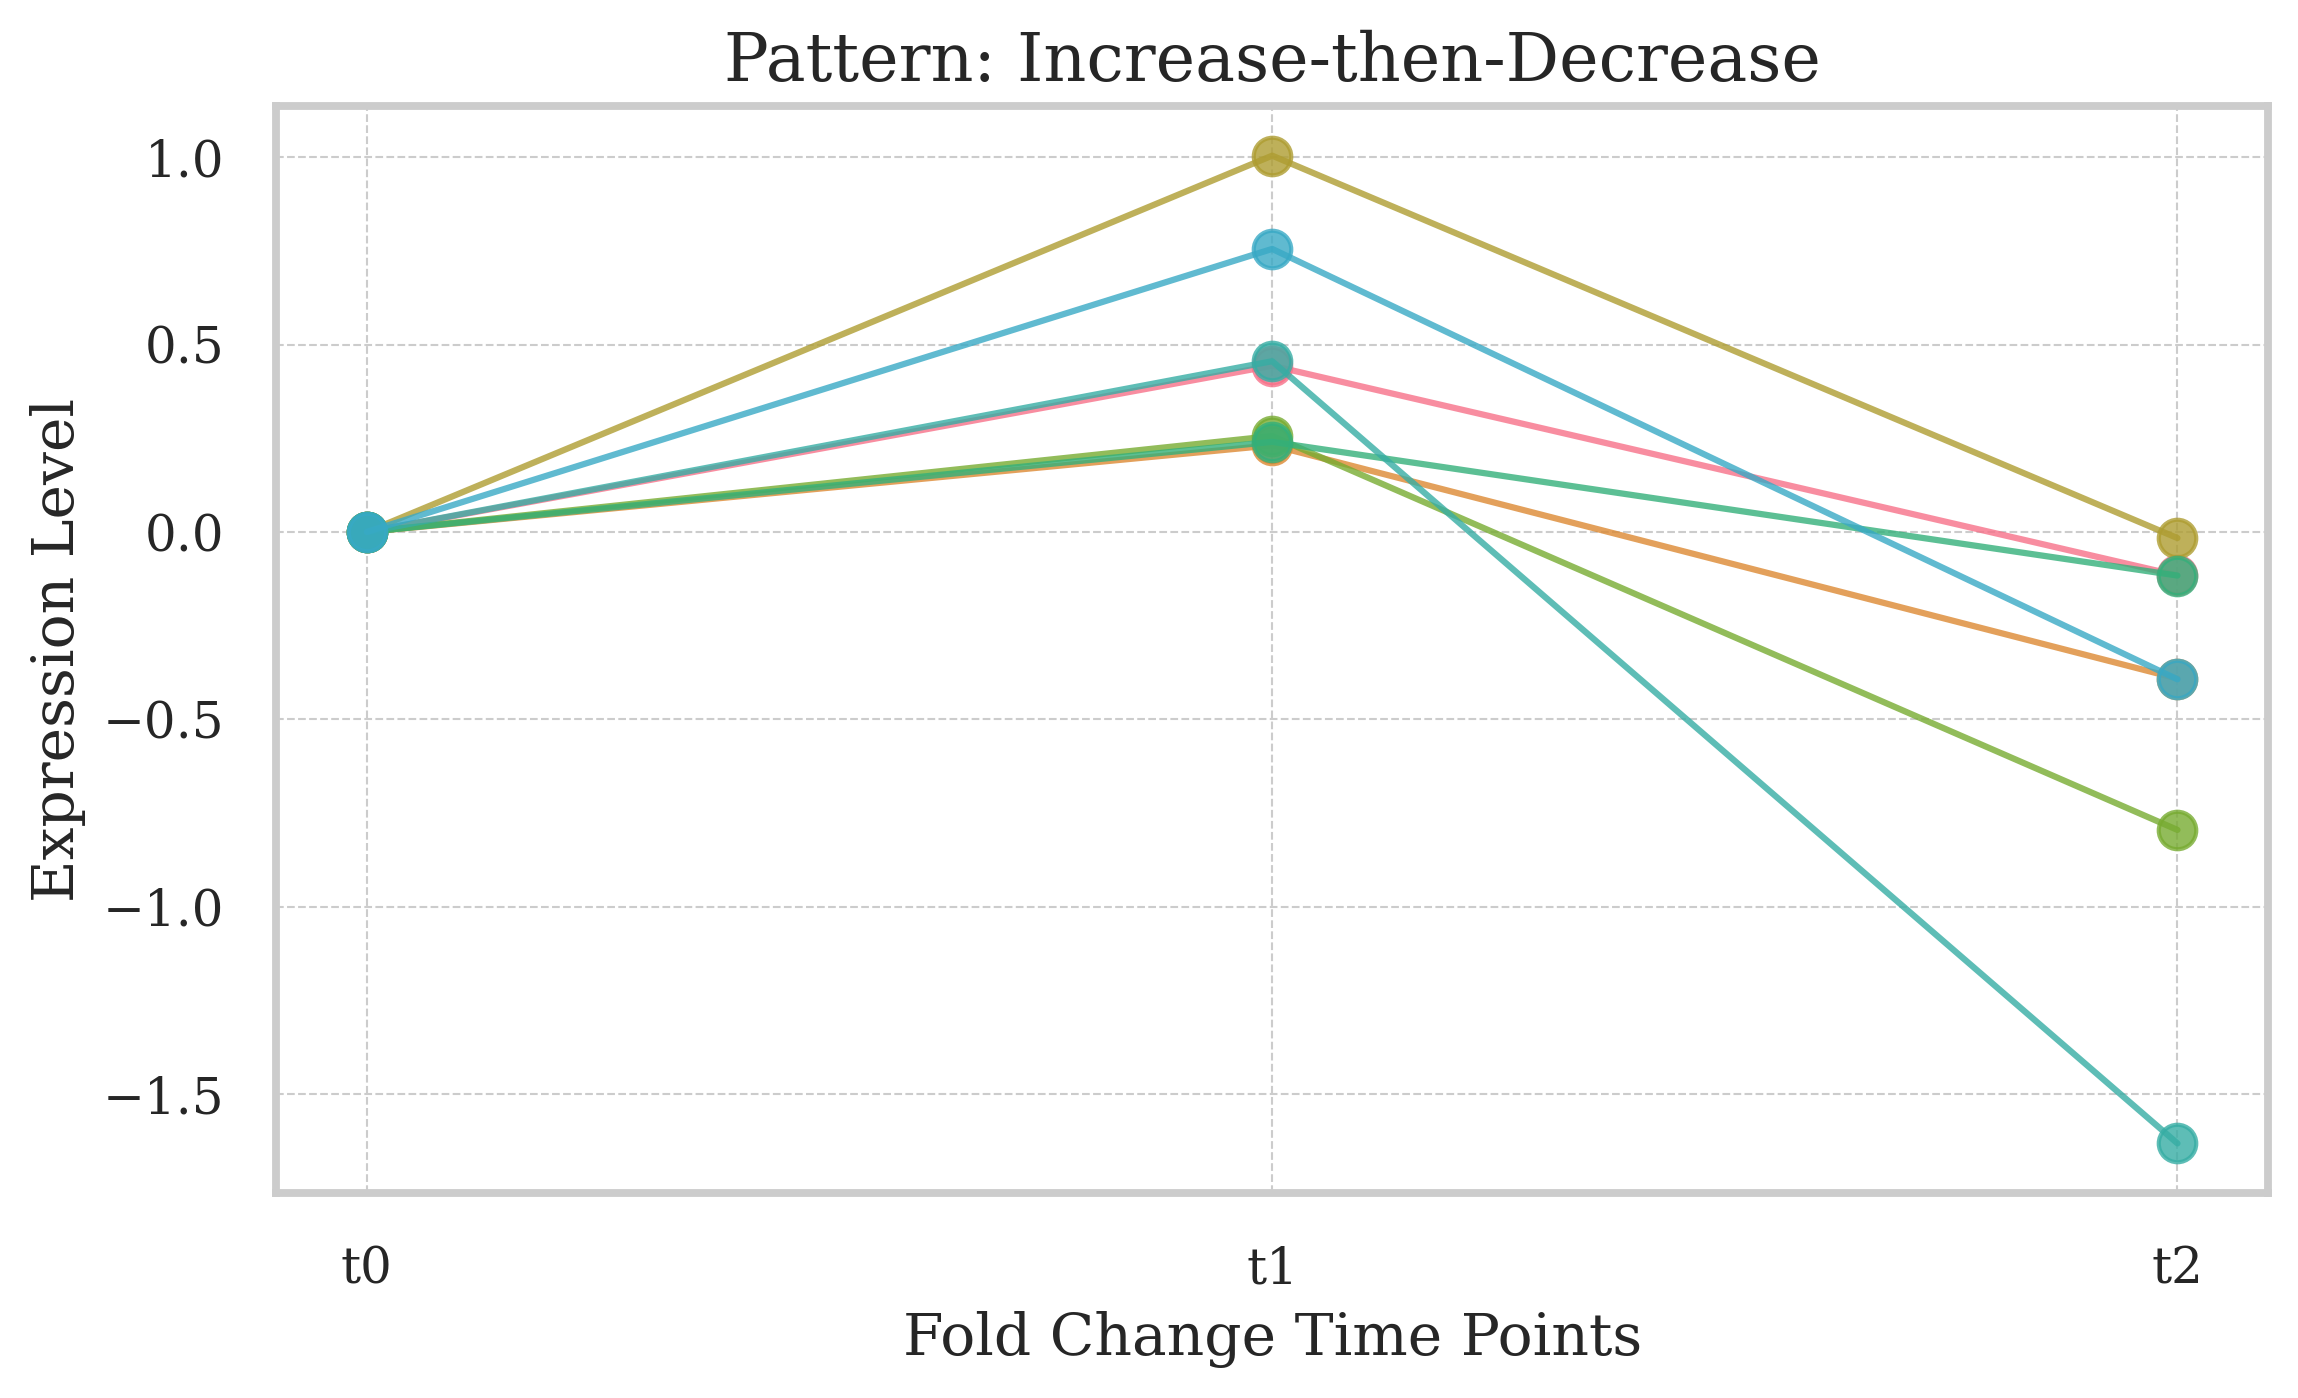

In [31]:
# all the plot without filter

for pattern in unique_patterns:
    subset = data_m[data_m['pattern'] == pattern]
    plt.figure(figsize=(8, 5))

    for i, (_, row) in enumerate(subset.iterrows()):
        color = palette[i % len(palette)]
        plt.plot(timepoints, row[timepoints], marker='o', linewidth=1.5, alpha=0.8, color=color)

    plt.title(f'Pattern: {pattern}', fontsize=16)
    plt.xlabel('Fold Change Time Points', fontsize=14)
    plt.ylabel('Expression Level', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Optional: comment this if too many lines
    #plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=8)

    plt.show()
    